In [1]:
# Библиотеки
# Реализация всех структур
import numpy as np

# Датасеты для первичной проверки качества моделей
from sklearn.datasets import make_blobs, make_circles
# classification_report
from sklearn.metrics import classification_report

# Графики и визуализация
from matplotlib import pyplot as plt

# Распаковка CIFAR-10
import pickle

# Для отображения структуры скачанных данных
import glob

# Чтобы засекать время работы алгоритма
import time

# Новый раздел

# Конструктор нейронной сети

Будем реализовывать по принципу действия (внешне) подобно тому, как это реализовано в pytorch

## Предварительные наработки

Так как я хочу, чтобы все работало так же как и в pytorch, мне нужно уметь передавать параметры в оптимизатор (а еще их градиенты, чтобы оптимизатор заработал просто и легко). Для этого я решил поместить параметры в отдельный класс. Дополнительно сразу добавим в него инициализацию. Также для удобства будем прямо тут хранить накопленные моменты для алгоритма Adam

In [2]:
class Parameters:
    """Здесь будут храниться параметры и их градиенты

    shape : tuple or int
        Определяет размер массива параметров
    """
    def __init__(self, shape):
        self.shape = shape
        self.params = np.zeros(shape)
        self.grads = np.zeros(shape)
        self.m = None
        self.v = None

    def _init_params(self, method='kaiming'):
        """Инициализация параметров

        ---------
        Параметры
        ---------
        method : str (default='kaiming')
            Метод инициализации параметров
            Пока доступен только 'kaiming'
        """
        if method=='kaiming':
            self.params = np.random.normal(loc=0, 
                scale=np.sqrt(2 / self.shape[0]), 
                size=self.shape)

#### Sequential

Для того, чтобы не реализовывать полный функционал pytorch (ибо это как минимум издевательство), оставим лишь возможность реализовывать модели с помощью некого подобия nn.Sequential. По сути это класс, в котором будет храниться описание сети и который будет обеспечивать взаимодействие с остальными структурами. Для дальнейшей реализации нам необходимы у данного класса следующие методы:

* `forward(x)` -- должен выполнять forward-pass всей модели
* `__call__(x)` -- должен делать то же, что и `forward(x)`
* `parameters()` -- должен возвращать все параметры модели для передачи их в оптимизатор
* `zero_grad()` -- обнуление градиентов всех параметров модели (мы будем накапливать градиенты)

Свои тензора мы реализовывать не будем (сложно и зачем?), но нам нужно выход модели передать функции ошибки, для этого мы засунем выход в специальную структуру, которую назовем громким словом Tensor, которая по сути кроме выхода будет содержать еще и ссылку на модель

In [3]:
class Tensor:
    """Будет хранить выход из модели и иметь ссылку на саму модель

    array
        Массив данных, которые будут на выходе
    
    model (default=None)
        Модель, на которую будет ссылаться тензор
    """
    def __init__(self, array, model=None):
        self.array = array
        self.model = model

    def __repr__(self):
        return str(self.array)

Однако после вычисления ошибки, (с которой мы будем разбираться далее), нам нужно уметь делать backpropagation (именно для этого мне ссылка на модель и нужна). Для этого нашему классу мы добавим еще один метод:
* `_compute_gradients(self, grads)`

Также для работы с Batch norm или Dropout нам нужны у модели методы

* `train()`
* `eval()`

In [4]:
class Sequential:
    """Определяет структуру нейронной сети

    ---------
    Параметры
    ---------
    args
        Последовательность элементов нейронной сети
    """
    def __init__(self, *args):
        if len(args) == 0:
            msg = "В последовательности должен быть хотя бы один элемент"
            raise ValueError(msg)

        self.modules = args

    def forward(self, inpt):
        """Делает forward pass модели
        """
        for module in self.modules:
            inpt = module.forward(inpt)

        return Tensor(inpt, self)

    def __call__(self, *inpt):
        return self.forward(*inpt)

    def parameters(self):
        """Возвращает параметры всех модулей модели, генератор"""
        for module in self.modules:
            params = module.parameters()
            if isinstance(params, tuple):
                for param in params:
                    yield param
            else:
                yield params

    def zero_grad(self):
        """Обнуляет все накопленные градиенты"""
        for module in self.modules:
            module._zero_grad()

    def _compute_gradients(self, grads):
        """Считает градиенты всех элементов"""
        for module in reversed(self.modules):
            grads = module._compute_gradients(grads)

    def train(self):
        """Переводит модель в режим обучения"""
        for module in self.modules:
            module._train()

    def eval(self):
        """Переводит модель в режим оценки и предсказания"""
        for module in self.modules:
            module._eval()

    def __repr__(self):
        string = 'Sequential(\n\t'
        string += ',\n\t'.join(map(str, self.modules))
        string += '\n)'
        return string

#### Оптимизаторы

Прежде чем писать структуру самой сети, напишем что-либо, что позволит нам произвести отладку, а конкретно функцию ошибки (начнем с простого, `mse_loss`) и оптимизатор (для начала хватит и обычного градиентного спуска, так как его нет в pytorch, то назовем его `GD`). 

С данным оптимизатором все совсем просто. Тут нужно реализовать две функции
* `zero_grad()` -- обнуление градиентов всех переданных параметров
* `step()` -- обновить все значения параметров

In [5]:
class GD:
    """Реализует обчный градиентный спуск

    ---------
    Параметры
    ---------
    params
        Параметры, передаваемые из модели

    lr : float (default=3e-4)
        Learning rate
    """
    def __init__(self, params, lr=3e-4):
        self.params = list(params)
        self.lr = lr

    def zero_grad(self):
        for param in self.params:
            param.grads = np.zeros(param.shape)

    def step(self):
        for param in self.params:
            param.params = param.params - self.lr * param.grads

В процессе отладки я в какой-то момент напоролся на не самое хорошее (как мне тогда казалось) поведение обычного градиентного спуска, поэтому я для надежности реализовал Adam (который в принципе имеет ту же структуру, что и прошлый класс)

In [6]:
class Adam:
    """Реализует Adam

    ---------
    Параметры
    ---------
    params
        Параметры, передаваемые из модели

    lr : float (default=3e-4)
        Learning rate
    
    beta_1 : float (default=0.9)
        Параметр beta_1

    beta_2 : float (default=0.999)
        Параметр beta_2

    eps : float (default=1e-8)
        Параметр eps
    """
    def __init__(self, params, lr=3e-4, beta_1=0.9, beta_2=0.999, eps=1e-8):
        self.params = list(params)
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.eps = eps
        self.t = 0

        for param in self.params:
            param.m = np.zeros(param.shape)
            param.v = np.zeros(param.shape)

    def zero_grad(self):
        for param in self.params:
            param.grads = np.zeros(param.shape)

    def step(self):
        self.t += 1
        for param in self.params:
            param.m = self.beta_1 * param.m + (1 - self.beta_1) * param.grads
            m = param.m / (1 - self.beta_1 ** self.t)
            param.v = self.beta_2 * param.v \
                      + (1 - self.beta_2) * (param.grads ** 2)
            v = param.v / (1 - self.beta_2 ** self.t)

            param.params = param.params - self.lr * m / (np.sqrt(v) + self.eps)

#### Функция ошибки

С ошибкой чуть сложнее, тут впервые надо сделать вычисления

$$MSE = \frac{1}{N}\sum_{i=1}^N\left(x_i^{pred}-x_i^{true}\right)^2,$$

где $N$ -- размер входного вектора. Стоит отметить, что нам на вход придет батч, по которому мы сделаем усреднение. Помимо прочего от того, что мы получим на выходе нужно уметь вызывать `backward()` и `item()`, поэтому предварительно реализуем соответствующий класс

In [7]:
class Loss:
    """Объект, возвращаемый функцией ошибки
    По сути контейнер, содержащий величину ошибки,
    ее градиент и ссылку на модель, чьи веса нужно обновить

    ---------
    Параметры
    ---------
    loss
        Ошибка

    grad
        Градиент

    model
        Ссылка на модель
    """
    def __init__(self, loss, grad, model):
        self.loss = loss
        self.grad = grad
        self.model = model

    def item(self):
        """Возвращает величину ошибки"""
        return self.loss

    def backward(self):
        """Запускает backpropagation"""
        self.model._compute_gradients(self.grad)

    def __repr__(self):
        return str(self.loss)

Наконец можно реализовать функцию ошибки. Первым элементом будет на вход матрица размером $(M, N)$, где $M$ -- размер бача.

In [8]:
def mse_loss(inpt, target):
    """Реализует функцию ошибки

    ---------
    Параметры
    ---------
    inpt : Tensor
        Предсказание модели

    target
        Целевая функция

    ----------
    Возвращает
    ----------
    loss : Loss
        Ошибка
    """
    loss = (inpt.array - target) ** 2
    loss = loss / inpt.array.shape[-1]
    loss = loss.sum(-1)
    loss = loss / inpt.array.shape[0]
    loss = loss.sum()

    grad = 2 * (inpt.array - target)
    grad = grad / inpt.array.shape[-1]
    grad = grad / inpt.array.shape[0]

    return Loss(loss, grad, inpt.model)

#### Linear

Наконец-то все готово для написания самой сети. Для начала реализуем линейный слой (`Linear`) и активационную функцию ReLU (`ReLU`). Согласно описанному выше, нам нужно, чтобы были реализованы следующие функции:
* `forward(x)` -- помимо обычного forward-pass'а мы также сохраним на этом этапе переменные, которые потом могут нам понадобиться для вычислений градиента
* `__call__(x)` -- делает то же, что и `forward(x)`
* `parameters()` -- возвращает параметры слоя
* `zero_grad()` -- обнуляет все градиенты
* `_compute_gradients(grads)` -- считает градиенты
* `_train()` -- переводит модель в режим обучения
* `_eval()` -- переводит модель в режим оценки

Также надо обязательно добавить `__repr__()` для красивой визуализации.

Начнем с линейного слоя. На вход подаются данные размером $(M, N_{in})$, которые конвертируются в $(M, N_{out})$.

Для forward-pass'a имеем

$$out = in\cdot W + bias,$$

где $W$ -- матрица параметров. Для того, чтобы посчитать градиент по $in$ нам нужно градиенты, которые придут на вход домножить справа на транспонированную $W$, т.е.

$$grad_{in} = grad_{out}\cdot W^\top$$

Для вычисления градиента по параметрам (и автоматически их просуммировать по бачам), нам нужно посчитать

$$grad_W = in^\top\cdot grad_{out}$$

Необходимо также посчитать градиент по смещению -- это сумма по бачу градиентов

$$grad_{bias} = \sum_{i=1}^M grad_{out, i}$$

In [9]:
class Linear:
    """Реализует линейный слой сети

    ---------
    Параметры
    ---------
    in_dim : int
        Размер входных данных

    out_dim : int
        Размер данных на выходе из слоя

    bias : bool (default=True)
        Использовать смещение или нет
    """
    def __init__(self, in_dim, out_dim, bias=True):
        self.in_dim = in_dim
        self.hid_dim = out_dim
        self.bias = bias

        self.W = Parameters((in_dim, out_dim))
        self.W._init_params()

        self.b = Parameters(out_dim)

        self.inpt = None

    def forward(self, inpt):
        """Реализует forward-pass

        ---------
        Параметры
        ---------
        inpt : np.ndarray, shape=(M, N_in)
            Входные данные

        ----------
        Возвращает
        ----------
        output : np.ndarray, shape=(M, N_out)
            Выход слоя
        """
        self.inpt = inpt

        return np.dot(inpt, self.W.params) + self.b.params

    def __call__(self, *inpt):
        """Аналогично forward"""
        return self.forward(*inpt)

    def parameters(self):
        """Возвращает параметры модели"""
        return (self.W, self.b)

    def _zero_grad(self):
        """Обнуляет градиенты модели"""
        self.W.grads = np.zeros(self.W.shape)
        self.b.grads = np.zeros(self.b.shape)

    def _compute_gradients(self, grads):
        """Считает градиенты модели"""
        self.W.grads = self.W.grads + np.dot(self.inpt.T, grads)

        if self.bias:
            self.b.grads = self.b.grads + grads.sum(axis=0)
        return np.dot(grads, self.W.params.T)

    def _train(self):
        """Переводит модель в режим обучения"""
        pass

    def _eval(self):
        """Переводит модель в режим оценивания"""
        pass

    def __repr__(self):
        return "Linear({}, {}, bias={})".format(self.in_dim, self.hid_dim, 
                                                self.bias)

#### ReLU

Теперь к ReLU. Здесь должны быть реализованы все те же методы, однако есть ряд исключений. 

Модель не имеет параметров, однако для работоспособности методов выше, мы добавим параметр, состоящий из одного числа, который всегда будет равен нулю (как и его градиент).

В данном случае мы просто поэлементно должны сделать $\max(0, value)$ для forward-pass'а.

Для backward нам нужно градиент обнулить везде, где значение выхода меньше или равно 0.

In [10]:
class ReLU:
    """Реализует ReLU"""
    def __init__(self):
        self.params = Parameters(1)

        self.out = None

    def forward(self, inpt):
        """Реализует forward-pass

        ---------
        Параметры
        ---------
        inpt : np.ndarray, shape=(M, N_in)
            Входные данные

        ----------
        Возвращает
        ----------
        output : np.ndarray, shape=(M, N_in)
            Выход слоя
        """
        self.out = np.maximum(inpt, 0.)

        return self.out

    def __call__(self, *inpt):
        """Аналогично forward"""
        return self.forward(*inpt)

    def parameters(self):
        """Возвращает параметры модели"""
        return self.params

    def _zero_grad(self):
        """Обнуляет градиенты модели
        
        Не нужен в данном случае, 
        оставим для совместимости
        """
        pass

    def _compute_gradients(self, grads):
        """Считает градиенты модели"""
        return np.multiply((self.out > 0) * 1., grads)

    def _train(self):
        """Переводит модель в режим обучения"""
        pass

    def _eval(self):
        """Переводит модель в режим оценивания"""
        pass

    def __repr__(self):
        return "ReLU()"

### Первичная проверка работоспособности

Напишем функцию для визуализации, которую будем использовать позже

In [11]:
def visualize_cls_preds(X, model, th=0.5, borders=(-0.1, 0.5, 1.1), preds_dim=1,
                        colors=('tab:blue', 'tab:orange'), alpha=0.3):
    """Наглядная визуализация 2D двуклассовой классификации

    ---------
    Параметры
    ---------
    X
        Точки к которым деляются предсказания

    model
        Модель, с помощью которой делаются предсказания
    
    th : float (default=0.5)
        Трешхолд по которому делается отсечение

    borders : list or tuple (default=(-0.1, 0.5, 1.1))
        Границы по которым идет отсечение

    preds_dim : int (default=1)
        Размерность выхода предсказаний, если значение
        * 1, то будет класс 0, если значение меньше трешхолда, 
          1 иначе
        * 2, то класс 0 будет соответствовать меньшему числу,
          а 1 большему

    colors : list or tuple (default=('tab:blue', 'tab:orange'))
        Цвета, которыми будет визуализироваться предсказание

    alpha : float (default=0.3)
        Степень прозрачности областей
    """
    plt.figure(figsize=(10,7))

    preds = model(X).array
    if preds_dim == 1:
        preds = (preds.flatten() > th) * 1
    elif preds_dim == 2:
        preds = np.argmax(preds, axis=-1)

    for ind, cls in enumerate(sorted(set(preds))):
        plt.scatter(X[preds == cls][:, 0], X[preds == cls][:, 1], s=5, 
                    label=str(cls), c=colors[ind])

    min_x, max_x = np.min(X[:, 0]), np.max(X[:, 0])
    min_y, max_y = np.min(X[:, 1]), np.max(X[:, 1])

    delta_x = (max_x - min_x) / 8
    delta_y = (max_y - min_y) / 8

    x = np.linspace(min_x - delta_x, max_x + delta_x, 100)
    y = np.linspace(min_y - delta_y, max_y + delta_y, 100)
    xx, yy = np.meshgrid(x, y)
    xy = np.vstack([xx.ravel(), yy.ravel()]).T
    preds_xy = model.forward(xy).array
    if preds_dim == 1:
        preds_xy = (preds_xy > th) * 1
    elif preds_dim == 2:
        preds_xy = np.argmax(preds_xy, axis=-1)
    preds_xy = preds_xy.reshape(xx.shape)
    plt.contourf(xx, yy, preds_xy, levels=borders, 
                colors=colors, alpha=0.3)

    plt.title('Что предсказалось')
    plt.legend()
    plt.show()

Можно проверить как работает модель на двух простейших примерах (да, здесь классификация, но можно просто выставить трешхолд и использовать регрессию, а так имеем наглядную визуализацию).

Два классических примера на которых нейронные сети работают хорошо -- это две концентрические окружности и 4 облака точек с центрами в вершинах квадрата, при этом расположенные по диагонали облака имеют одинаковую метку.

Начнем с окружностей

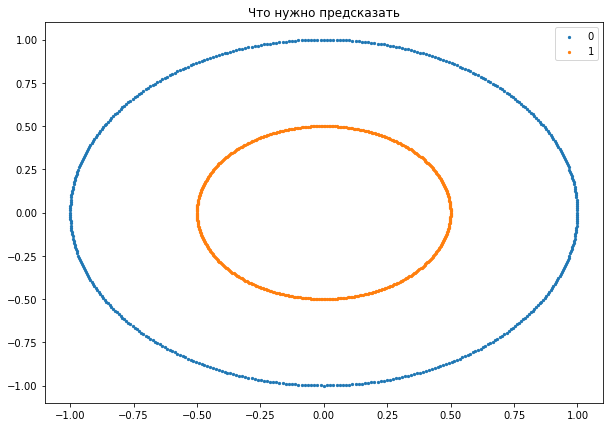

In [12]:
# Установим seed для воспроизводимости
np.random.seed(42)
dataset = make_circles(1000, factor=0.5, random_state=42)

X = dataset[0]
y = dataset[1]

plt.figure(figsize=(10, 7))

colors = ('tab:blue', 'tab:orange')

for ind, cls in enumerate(sorted(set(y))):
    plt.scatter(X[y == cls][:, 0], X[y == cls][:, 1], s=5, 
                label=str(cls), c=colors[ind])

plt.title('Что нужно предсказать')
plt.legend()
plt.show()

Создадим модель с тремя слоями

In [13]:
model = Sequential(
    Linear(2, 20),
    ReLU(),
    Linear(20, 10),
    ReLU(),
    Linear(10, 4),
    ReLU(),
    Linear(4, 1)
)
model

Sequential(
	Linear(2, 20, bias=True),
	ReLU(),
	Linear(20, 10, bias=True),
	ReLU(),
	Linear(10, 4, bias=True),
	ReLU(),
	Linear(4, 1, bias=True)
)

В качестве оптимизатора выберем Adam (он быстрее и лучше сходится)

In [14]:
optimizer = Adam(model.parameters(), 0.01)

Будем тренировать на 100 эпохах

In [15]:
for epoch in range(100):
    out = model.forward(X)

    loss = mse_loss(out, y.reshape((-1, 1)))
    #print(loss.item())

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

Визуализируем то, что выучила модель

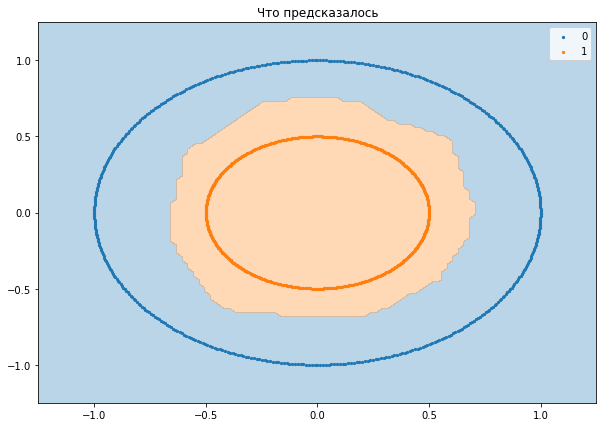

In [16]:
visualize_cls_preds(X, model)

Совпадение очевидно.

Посмотрим на второй датасет

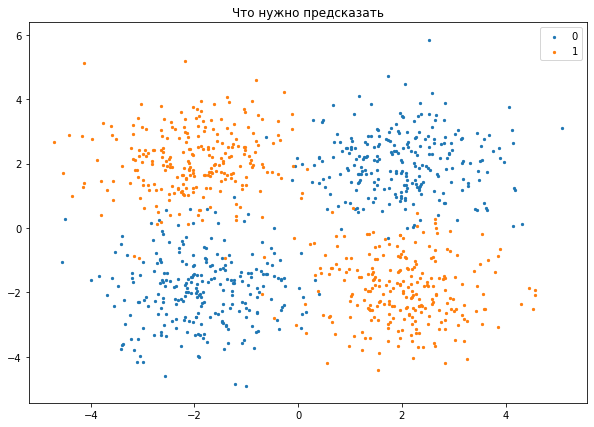

In [17]:
np.random.seed(42)
dataset = make_blobs(1000, 2, centers=[
                                       [2, 2], [2, -2],
                                       [-2, -2], [-2, 2]
], random_state=42)

X = dataset[0]
y = dataset[1]
y = y % 2

plt.figure(figsize=(10, 7))

colors = ('tab:blue', 'tab:orange')

for ind, cls in enumerate(sorted(set(y))):
    plt.scatter(X[y == cls][:, 0], X[y == cls][:, 1], s=5, 
                label=str(cls), c=colors[ind])

plt.title('Что нужно предсказать')
plt.legend()
plt.show()

Структуру сети изменять не будем

In [18]:
model = Sequential(
    Linear(2, 20),
    ReLU(),
    Linear(20, 10),
    ReLU(),
    Linear(10, 4),
    ReLU(),
    Linear(4, 1)
)
model

Sequential(
	Linear(2, 20, bias=True),
	ReLU(),
	Linear(20, 10, bias=True),
	ReLU(),
	Linear(10, 4, bias=True),
	ReLU(),
	Linear(4, 1, bias=True)
)

Оптимизатор тоже

In [19]:
optimizer = Adam(model.parameters(), 0.01)

Обучим модель на 100 эпохах

In [20]:
for epoch in range(100):
    out = model.forward(X)

    loss = mse_loss(out, y.reshape((-1, 1)))
    #print(loss.item())

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

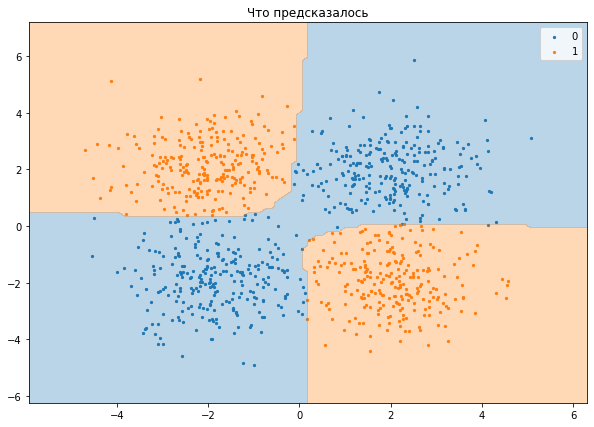

In [21]:
visualize_cls_preds(X, model)

Видно, что предсказание тоже достаточно хорошее, значит нейронная сеть работает

## Структуры необходимые для решения домашнего задания

### Hinge loss

Для нас для начала надо реализовать Hinge Loss, реализацию которого мы с одобрения автора этого задания возьмем с [Keras](https://keras.io/api/losses/hinge_losses/#categoricalhinge-function).

Данная функция ошибки имеет вид

$$loss = \max(neg - pos + 1, 0),$$

где слагаемые neg и pos определены следующим образом: пускай наш вектор предсказаний будет вектором, который предсказывает вероятности для каждого класса (обозначим его как $y_{pred}$), а целевой вектор ($y_{true}$) будет состоять из нулей и одной единицы, которая будет стоять на позиции, соответствующей номеру класса. Тогда $pos$ будет просто равен их скалярному произведению

$$pos = y_{true}\cdot y_{pred},$$

а $neg$ будет равен

$$neg = \max_i\left\{(1-y_{true, i})\cdot y_{pred, i}\right\}.$$

По сути $pos$ равен предсказанной вероятности для настоящего класса, а $neg$ -- максимальной предсказанной вероятности среди всех неверных классов. В идеале, если бы у нас все предсказания были от 0 до 1, то максимум в функции ошибки бы брать не пришлось, но если мы не будем ограничивать диапазон предсказания нашей модели, то разумно было бы обрезать все нулем снизу.

Рассмотрим градиент функции ошибки. Если $loss$ равен 0, то и градиент должен быть равен 0. В противном же случае $loss = neg - pos + 1$ и нам нужно отдельно посчитать градиенты для $neg$ и $pos$. Для $pos$ ответ тривиален

$$grad_{pos} = y_{true}$$

Для $neg$ это будет вектор из нулей и единицы, которая будет стоять на позиции, которая соответствует максимальному значению среди всех $y_{pred, i}$, где $i$ не является меткой настоящего класса.

Соответственно градиент ошибки будет состоять из нулей, одной единицы из $neg$ и одной минус единицы из $pos$.

Наконец стоит отметить, что по бачу мы все будем усреднять, поэтому градиент будет необходимо поделить на размер бача

In [22]:
def hinge_loss(inpt, target):
    """Реализует функцию ошибки hinge loss

    ---------
    Параметры
    ---------
    inpt : Tensor
        Предсказание модели

    target
        Список реальных классов
        Одномерный массив

    ----------
    Возвращает
    ----------
    loss : Loss
        Ошибка
    """
    # Мы должны сконвертировать массив реальных меток
    # в двумерный массив размера (N, C),
    # где N -- число элементов
    # С -- число классов
    C = inpt.array.shape[-1]
    target = np.eye(C)[target]

    pos = np.sum(target * inpt.array, axis=-1)
    neg = np.amax((1. - target) * inpt.array, axis=-1)
    loss = np.maximum(0., neg - pos + 1.)
    # Сразу выделим те элементы, для которых loss нулевой
    loss_gt_0 = ((loss > 0) * 1.)[:, np.newaxis]
    loss = loss / inpt.array.shape[0]
    loss = loss.sum()

    grad_pos = target
    grad_neg = np.argmax((1. - target) * inpt.array, axis=-1)
    grad_neg = np.eye(C)[grad_neg]
    grad = grad_neg - grad_pos
    grad = grad * loss_gt_0
    grad = grad / inpt.array.shape[0]

    return Loss(loss, grad, inpt.model)

#### Проверка работоспособности

Рассмотрим те же датасеты, что и раньше

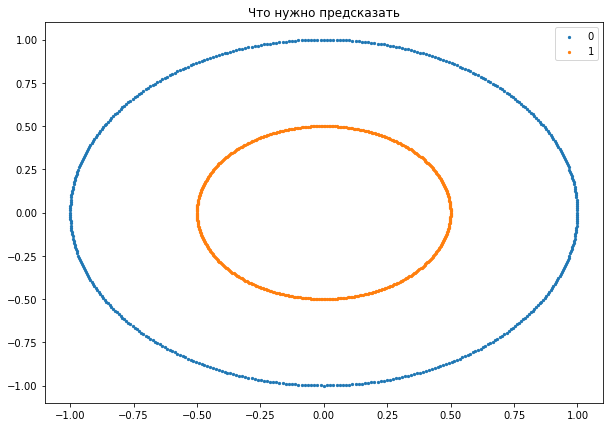

In [23]:
np.random.seed(42)
dataset = make_circles(1000, factor=0.5, random_state=42)

X = dataset[0]
y = dataset[1]

plt.figure(figsize=(10, 7))

colors = ('tab:blue', 'tab:orange')

for ind, cls in enumerate(sorted(set(y))):
    plt.scatter(X[y == cls][:, 0], X[y == cls][:, 1], s=5, 
                label=str(cls), c=colors[ind])

plt.title('Что нужно предсказать')
plt.legend()
plt.show()

Сеть также менять не будем, только на выходе теперь будет два числа, а не одно

In [24]:
model = Sequential(
    Linear(2, 20),
    ReLU(),
    Linear(20, 10),
    ReLU(),
    Linear(10, 4),
    ReLU(),
    Linear(4, 2)
)
model

Sequential(
	Linear(2, 20, bias=True),
	ReLU(),
	Linear(20, 10, bias=True),
	ReLU(),
	Linear(10, 4, bias=True),
	ReLU(),
	Linear(4, 2, bias=True)
)

Оставим тот же оптимизатор

In [25]:
optimizer = Adam(model.parameters(), 0.01)

И также 100 эпох (пока что без анализа качества и скорости сходимости)

In [26]:
for epoch in range(100):
    out = model.forward(X)

    loss = hinge_loss(out, y)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

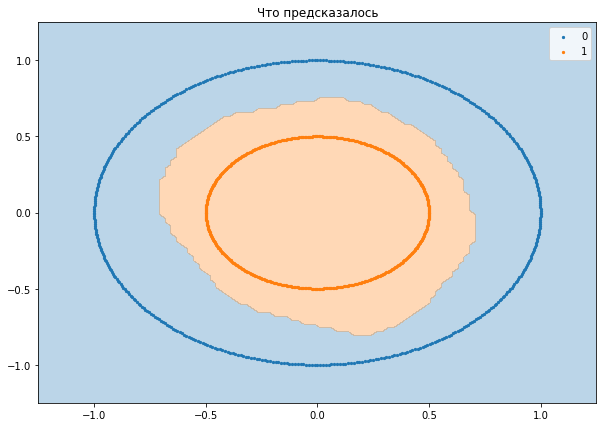

In [27]:
visualize_cls_preds(X, model, preds_dim=2)

Точки разделены верно

Рассмотрим второй пример, сгенерируем те же данные

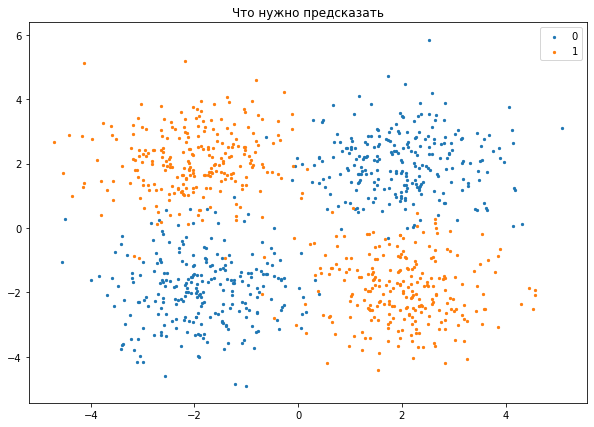

In [28]:
np.random.seed(42)
dataset = make_blobs(1000, 2, centers=[
                                       [2, 2], [2, -2],
                                       [-2, -2], [-2, 2]
], random_state=42)

X = dataset[0]
y = dataset[1]
y = y % 2

plt.figure(figsize=(10, 7))

colors = ('tab:blue', 'tab:orange')

for ind, cls in enumerate(sorted(set(y))):
    plt.scatter(X[y == cls][:, 0], X[y == cls][:, 1], s=5, 
                label=str(cls), c=colors[ind])

plt.title('Что нужно предсказать')
plt.legend()
plt.show()

А вот с моделью дело обстоит куда интереснее. В данном случае градиент функции ошибки не зависит от величины предсказания (что на самом деле плохо для оптимизации. Если оставить модель с теми же переметрами, что были раньше (а надо заметить, что параметров модели меньше, чем размер датасета), то оптимизатор найдет две точки локального равновесия и будет между ними метаться, не в силах выбраться из этой западни. Увеличение числа весов модели спасает нас в данной ситуации и позволяет правильно разделить множества.

In [29]:
model = Sequential(
    Linear(2, 40),
    ReLU(),
    Linear(40, 20),
    ReLU(),
    Linear(20, 8),
    ReLU(),
    Linear(8, 2)
)
model

Sequential(
	Linear(2, 40, bias=True),
	ReLU(),
	Linear(40, 20, bias=True),
	ReLU(),
	Linear(20, 8, bias=True),
	ReLU(),
	Linear(8, 2, bias=True)
)

In [30]:
optimizer = Adam(model.parameters(), 0.01)

In [31]:
for epoch in range(100):
    out = model.forward(X)

    loss = hinge_loss(out, y)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

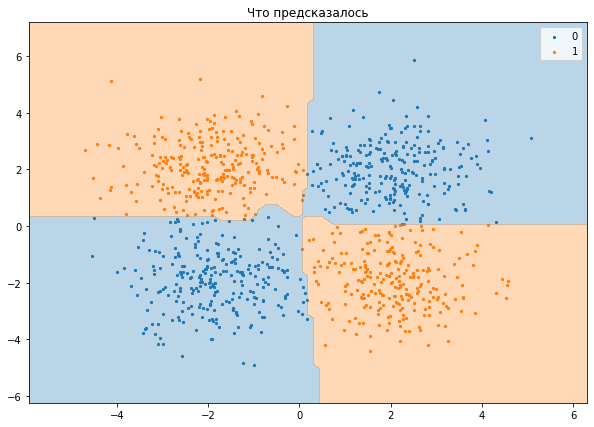

In [32]:
visualize_cls_preds(X, model, preds_dim=2)

Итак, эта модель тоже работает, хотя и заметно хуже, так как требует более сложную модель для качественного предсказания, что может упереться в нехватку данных.

### Sigmoid

Помимо ReLU нам нужно исследовать сигмоиду и гиперболический тангенс в качестве функций ошибки. Начнем с сигмоиды.

Выражение для сигмоиды имеет вид

$$\sigma(x) = \frac{1}{1+\exp(-x)}$$

Выражение для производной имеет вид

$$\sigma'(x) = \frac{\exp(-x)}{\left(1+\exp(-x)\right)^2} = \sigma(x)\cdot (1-\sigma(x))$$

In [33]:
class Sigmoid:
    """Реализует сигмоиду"""
    def __init__(self):
        self.params = Parameters(1)

        self.out = None

    def forward(self, inpt):
        """Реализует forward-pass

        ---------
        Параметры
        ---------
        inpt : np.ndarray, shape=(M, N_in)
            Входные данные

        ----------
        Возвращает
        ----------
        output : np.ndarray, shape=(M, N_in)
            Выход слоя
        """
        self.out = 1. / (1. + np.exp(-inpt))

        return self.out

    def __call__(self, *inpt):
        """Аналогично forward"""
        return self.forward(*inpt)

    def parameters(self):
        """Возвращает параметры модели"""
        return self.params

    def _zero_grad(self):
        """Обнуляет градиенты модели
        
        Не нужен в данном случае, 
        оставим для совместимости
        """
        pass

    def _compute_gradients(self, grads):
        """Считает градиенты модели"""
        return np.multiply(np.multiply(self.out, 1. - self.out), grads)

    def _train(self):
        """Переводит модель в режим обучения"""
        pass

    def _eval(self):
        """Переводит модель в режим оценивания"""
        pass

    def __repr__(self):
        return "Sigmoid()"

#### Проверка работоспособности

Далее я не буду приводить описание и показывать как выглядит датасет. Просто покажу вывод и что все работает. В первых моделях заменим ReLU на Sigmoid.

Посмотрим на первый датасет. Число эпох пришлось увеличить до 150 для того, чтобы все сошлось.

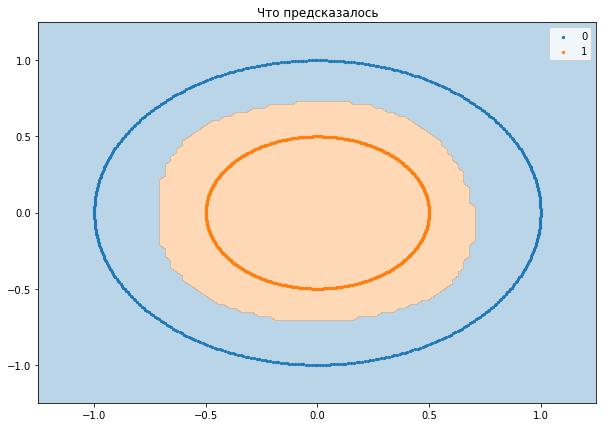

In [34]:
np.random.seed(42)
dataset = make_circles(1000, factor=0.5, random_state=42)

X = dataset[0]
y = dataset[1]

model = Sequential(
    Linear(2, 20),
    Sigmoid(),
    Linear(20, 10),
    Sigmoid(),
    Linear(10, 4),
    Sigmoid(),
    Linear(4, 1)
)

optimizer = Adam(model.parameters(), 0.01)

for epoch in range(150):
    out = model.forward(X)

    loss = mse_loss(out, y.reshape((-1, 1)))
    #print(loss.item())

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

visualize_cls_preds(X, model)

Посмотрим на всторой датасет. Здесь без изменений.

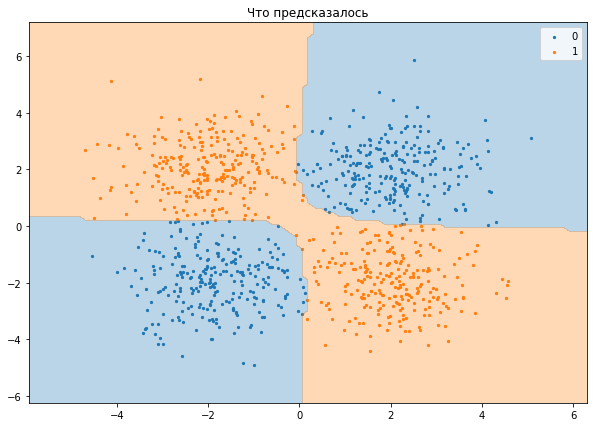

In [35]:
np.random.seed(42)
dataset = make_blobs(1000, 2, centers=[
                                       [2, 2], [2, -2],
                                       [-2, -2], [-2, 2]
], random_state=42)

X = dataset[0]
y = dataset[1]
y = y % 2

model = Sequential(
    Linear(2, 20),
    Sigmoid(),
    Linear(20, 10),
    Sigmoid(),
    Linear(10, 4),
    Sigmoid(),
    Linear(4, 1)
)

optimizer = Adam(model.parameters(), 0.01)

for epoch in range(150):
    out = model.forward(X)

    loss = mse_loss(out, y.reshape((-1, 1)))
    #print(loss.item())

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

visualize_cls_preds(X, model)

Как видим, все работает

### Tanh

Теперь реализуем гиперболический тангенс. 

По сути это $2\cdot\sigma(2x) - 1$:

$$\tanh(x) = \frac{\exp(x) - \exp(-x)}{\exp(x)+\exp(-x)} = \frac{1-\exp(-2x)}{1+\exp(-2x)} = \frac{2 - (1+\exp(-2x))}{1+\exp(-2x)} = 2\cdot\sigma(2x)-1$$

Рассмотрим теперь производную

$$\tanh'(x) = 4\cdot\sigma(2x)\cdot (1-\sigma (2x)) = [1 + (2\cdot\sigma(2x)-1)]\cdot[1-(2\cdot\sigma(2x)-1)]=(1+\tanh(x))\cdot(1-\tanh(x))$$

In [36]:
class Tanh:
    """Реализует гиперболический тангенс"""
    def __init__(self):
        self.params = Parameters(1)

        self.out = None

    def forward(self, inpt):
        """Реализует forward-pass

        ---------
        Параметры
        ---------
        inpt : np.ndarray, shape=(M, N_in)
            Входные данные

        ----------
        Возвращает
        ----------
        output : np.ndarray, shape=(M, N_in)
            Выход слоя
        """
        self.out = 2. / (1. + np.exp(-2 * inpt)) - 1.

        return self.out

    def __call__(self, *inpt):
        """Аналогично forward"""
        return self.forward(*inpt)

    def parameters(self):
        """Возвращает параметры модели"""
        return self.params

    def _zero_grad(self):
        """Обнуляет градиенты модели
        
        Не нужен в данном случае, 
        оставим для совместимости
        """
        pass

    def _compute_gradients(self, grads):
        """Считает градиенты модели"""
        return np.multiply(np.multiply(1 + self.out, 1. - self.out), grads)

    def _train(self):
        """Переводит модель в режим обучения"""
        pass

    def _eval(self):
        """Переводит модель в режим оценивания"""
        pass

    def __repr__(self):
        return "Tanh()"

#### Проверка работоспособности

Первый датасет. Число эпох оставим равным 100.

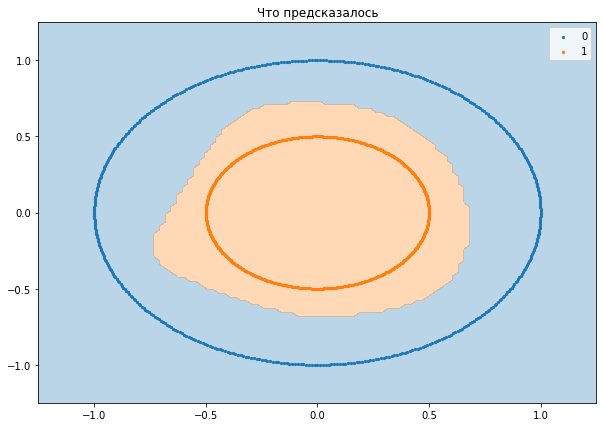

In [37]:
np.random.seed(42)
dataset = make_circles(1000, factor=0.5, random_state=42)

X = dataset[0]
y = dataset[1]

model = Sequential(
    Linear(2, 20),
    Tanh(),
    Linear(20, 10),
    Tanh(),
    Linear(10, 4),
    Tanh(),
    Linear(4, 1)
)

optimizer = Adam(model.parameters(), 0.01)

for epoch in range(100):
    out = model.forward(X)

    loss = mse_loss(out, y.reshape((-1, 1)))
    #print(loss.item())

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

visualize_cls_preds(X, model)

Второй датасет. Оставим так же как и раньше.

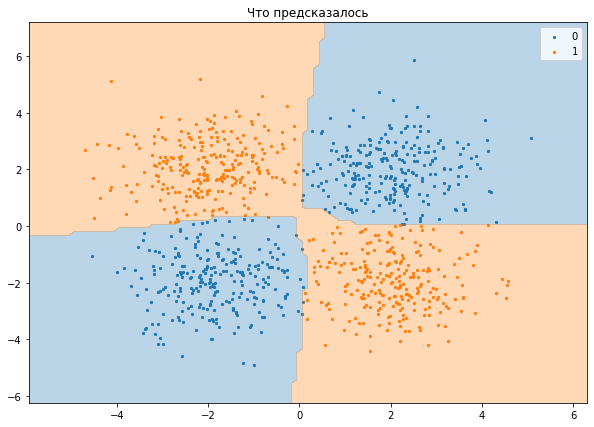

In [38]:
np.random.seed(42)
dataset = make_blobs(1000, 2, centers=[
                                       [2, 2], [2, -2],
                                       [-2, -2], [-2, 2]
], random_state=42)

X = dataset[0]
y = dataset[1]
y = y % 2

model = Sequential(
    Linear(2, 20),
    Tanh(),
    Linear(20, 10),
    Tanh(),
    Linear(10, 4),
    Tanh(),
    Linear(4, 1)
)

optimizer = Adam(model.parameters(), 0.01)

for epoch in range(150):
    out = model.forward(X)

    loss = mse_loss(out, y.reshape((-1, 1)))
    #print(loss.item())

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

visualize_cls_preds(X, model)

Как видно, модель работает

### Dropout

На самом деле мы здесь реализуем не dropout, а inverted dropout, как это и реализовано в большинстве библиотек.

В данном случае структура с вероятностью $p$ во время обучения будет занулять элементы пришедшей в нее матрицы. А после данная матрица будет умножаться на $\frac{1}{1-p}$ для компенсации на этапе оценки.

На этапе оценки этот слой не будет делать ничего

In [39]:
class Dropout:
    """Реализует dropout
    
    ---------
    Параметры
    ---------
    p : float (default=0.5)
        Вероятность зануления элемента
    """
    def __init__(self, p=0.5):
        self.p = p

        self.params = Parameters(1)
        self.regime = "Train"
        self.mask = None

    def forward(self, inpt):
        """Реализует forward-pass

        ---------
        Параметры
        ---------
        inpt : np.ndarray, shape=(M, N_in)
            Входные данные

        ----------
        Возвращает
        ----------
        output : np.ndarray, shape=(M, N_in)
            Выход слоя
        """
        if self.regime == "Eval":
            return inpt

        self.mask = (np.random.rand(*inpt.shape) > self.p) * 1.
        self.out = self.mask * inpt
        self.out = self.out / (1 - self.p)

        return self.out

    def __call__(self, *inpt):
        """Аналогично forward"""
        return self.forward(*inpt)

    def parameters(self):
        """Возвращает параметры модели"""
        return self.params

    def _zero_grad(self):
        """Обнуляет градиенты модели
        
        Не нужен в данном случае, 
        оставим для совместимости
        """
        pass

    def _compute_gradients(self, grads):
        """Считает градиенты модели"""
        if self.regime == "Eval":
            raise RuntimeError("Нельзя посчитать градиенты в режиме оценки")
        return np.multiply(self.mask, grads) / (1 - self.p)

    def _train(self):
        """Переводит модель в режим обучения"""
        self.regime = "Train"

    def _eval(self):
        """Переводит модель в режим оценивания"""
        self.regime = "Eval"

    def __repr__(self):
        return f"Dropout(p={self.p})"

#### Проверка работоспособности

Увеличим размер модели в 2 раза и выставим $p=0.5$

Для первого датасета мне удалось добиться сходимости только за 300 эпох. Что наталкивает на мысль, что с dropout модель учится заметно медленнее.

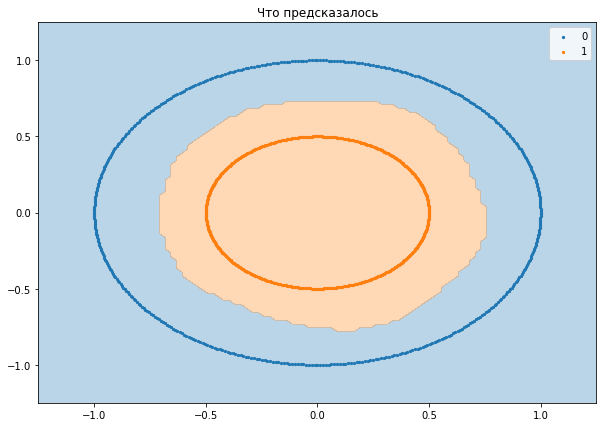

In [40]:
np.random.seed(42)
dataset = make_circles(1000, factor=0.5, random_state=42)

X = dataset[0]
y = dataset[1]

model = Sequential(
    Linear(2, 40),
    ReLU(),
    Dropout(0.5),
    Linear(40, 20),
    ReLU(),
    Dropout(0.5),
    Linear(20, 8),
    ReLU(),
    Dropout(0.5),
    Linear(8, 1)
)

optimizer = Adam(model.parameters(), 0.01)

for epoch in range(300):
    model.train()
    out = model.forward(X)

    loss = mse_loss(out, y.reshape((-1, 1)))
    #print(loss.item())

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

model.eval()
visualize_cls_preds(X, model)

Для второго датасета. В данном случае dropout мы уменьшим до 0.3, так как обучение шло слишком медленно. Достаточно приемлего качества удалось достичь лишь 1000 итерациях. Что еще раз показывает, что с dropout все учится значительно медленнее.

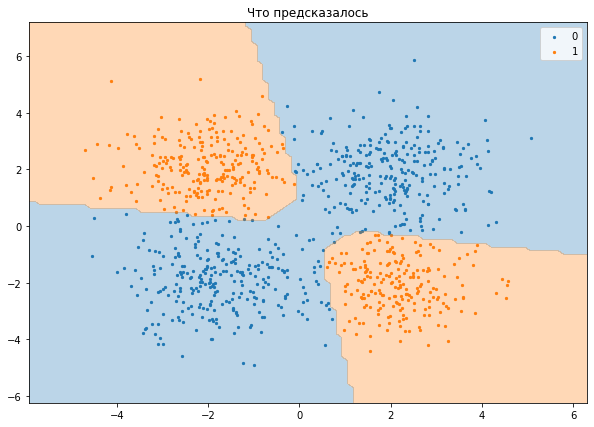

In [41]:
np.random.seed(42)
dataset = make_blobs(1000, 2, centers=[
                                       [2, 2], [2, -2],
                                       [-2, -2], [-2, 2]
], random_state=42)

X = dataset[0]
y = dataset[1]
y = y % 2

model = Sequential(
    Linear(2, 40),
    ReLU(),
    Dropout(0.3),
    Linear(40, 20),
    ReLU(),
    Dropout(0.3),
    Linear(20, 8),
    ReLU(),
    Dropout(0.3),
    Linear(8, 1)
)

optimizer = Adam(model.parameters(), 0.01)


loss_history = []
for epoch in range(1000):
    model.train()
    out = model.forward(X)

    loss = mse_loss(out, y.reshape((-1, 1)))
    loss_history.append(loss.item())

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

model.eval()
visualize_cls_preds(X, model)

### L1

Не самый лучший подход. У проксимальных методов и так все плохо со сходимостью, а тут еще и нормально не дифференцируемый hinge loss.

В общем, это реализуем как модификацию оптимизатора. Добавлять еще одно слагаемое к функции ошибки я смысла не вижу, а так это позволит нам получить нормализацию.

В действительности к функции ошибки должно быть добавлено слагаемое

$$l_1 = \alpha_1\sum_{i, j}|w_{i,j}|,$$

где $i$ нумерует слой, а $j$ нумерует вес в слое. Поэтому, когда мы будем считать градиенты у нас к градиентам добавится слагаемое

$$\frac{\partial l_1}{\partial w_{i,j}} = \alpha_1\cdot\text{sign}w_{i,j},$$

что можно просто реализовать в оптимизаторе

In [42]:
class GD:
    """Реализует обчный градиентный спуск

    ---------
    Параметры
    ---------
    params
        Параметры, передаваемые из модели

    lr : float (default=3e-4)
        Learning rate

    alpha1 : float (default=None)
        Если не None, то применяет l_1 регуляризацию
        с параметром alpha_1
    """
    def __init__(self, params, lr=3e-4, alpha1=None):
        self.params = list(params)
        self.lr = lr
        self.alpha1 = alpha1

    def zero_grad(self):
        for param in self.params:
            param.grads = np.zeros(param.shape)

    def step(self):
        for param in self.params:
            grads = np.zeros(param.grads.shape)
            if not (self.alpha1 is None):
                grads += self.alpha1 * np.sign(param.params)
            grads += param.grads

            param.params = param.params - self.lr * grads

In [43]:
class Adam:
    """Реализует Adam

    ---------
    Параметры
    ---------
    params
        Параметры, передаваемые из модели

    lr : float (default=3e-4)
        Learning rate
    
    beta_1 : float (default=0.9)
        Параметр beta_1

    beta_2 : float (default=0.999)
        Параметр beta_2

    eps : float (default=1e-8)
        Параметр eps

    alpha1 : float (default=None)
        Если не None, то применяет l_1 регуляризацию
        с параметром alpha_1
    """
    def __init__(self, params, lr=3e-4, beta_1=0.9, beta_2=0.999, eps=1e-8,
                 alpha1=None):
        self.params = list(params)
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.eps = eps
        self.alpha1 = alpha1
        self.t = 0

        for param in self.params:
            param.m = np.zeros(param.shape)
            param.v = np.zeros(param.shape)

    def zero_grad(self):
        for param in self.params:
            param.grads = np.zeros(param.shape)

    def step(self):
        self.t += 1
        for param in self.params:
            grads = np.zeros(param.grads.shape)
            if not (self.alpha1 is None):
                grads += self.alpha1 * np.sign(param.params)
            grads += param.grads

            param.m = self.beta_1 * param.m + (1 - self.beta_1) * grads
            m = param.m / (1 - self.beta_1 ** self.t)
            param.v = self.beta_2 * param.v \
                      + (1 - self.beta_2) * (grads ** 2)
            v = param.v / (1 - self.beta_2 ** self.t)

            param.params = param.params - self.lr * m / (np.sqrt(v) + self.eps)

#### Проверка работоспособности

Рассмотрим только оптимизатор Adam

Здесь я бы хотел показать поведение оптимизатора при достаточно большом значении $\alpha_1$. Выделяемая область становится похожа на ромб

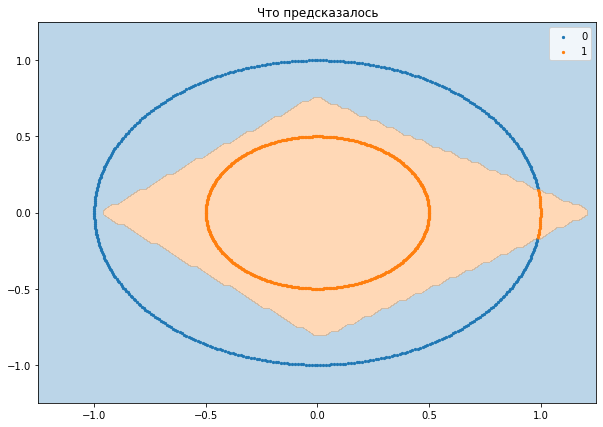

In [44]:
np.random.seed(42)
dataset = make_circles(1000, factor=0.5, random_state=42)

X = dataset[0]
y = dataset[1]

model = Sequential(
    Linear(2, 20),
    ReLU(),
    Linear(20, 10),
    ReLU(),
    Linear(10, 4),
    ReLU(),
    Linear(4, 1)
)

optimizer = Adam(model.parameters(), 0.01, alpha1=0.05)

for epoch in range(150):
    out = model.forward(X)

    loss = mse_loss(out, y.reshape((-1, 1)))
    #print(loss.item())

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

visualize_cls_preds(X, model)

При достаточно низком значении предсказание идет нормально

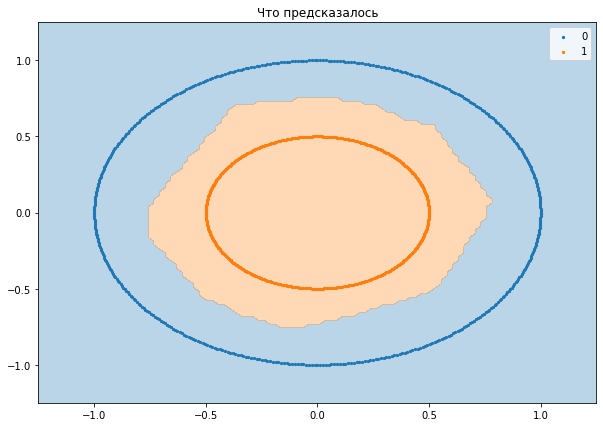

In [45]:
np.random.seed(42)
dataset = make_circles(1000, factor=0.5, random_state=42)

X = dataset[0]
y = dataset[1]

model = Sequential(
    Linear(2, 20),
    ReLU(),
    Linear(20, 10),
    ReLU(),
    Linear(10, 4),
    ReLU(),
    Linear(4, 1)
)

optimizer = Adam(model.parameters(), 0.01, alpha1=0.001)

for epoch in range(150):
    out = model.forward(X)

    loss = mse_loss(out, y.reshape((-1, 1)))
    #print(loss.item())

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

visualize_cls_preds(X, model)

На втором датасете все работает нормально

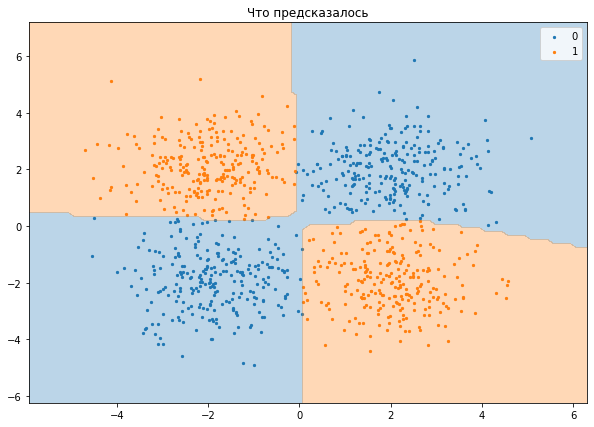

In [46]:
np.random.seed(42)
dataset = make_blobs(1000, 2, centers=[
                                       [2, 2], [2, -2],
                                       [-2, -2], [-2, 2]
], random_state=42)

X = dataset[0]
y = dataset[1]
y = y % 2

model = Sequential(
    Linear(2, 20),
    ReLU(),
    Linear(20, 10),
    ReLU(),
    Linear(10, 4),
    ReLU(),
    Linear(4, 1)
)

optimizer = Adam(model.parameters(), 0.01, alpha1=0.001)

for epoch in range(150):
    out = model.forward(X)

    loss = mse_loss(out, y.reshape((-1, 1)))
    #print(loss.item())

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

visualize_cls_preds(X, model)

### L2

Здесь ситуация такая же, как и в предыдущем случае, только тут имеет место дифференцируемость

$$l_2 = \frac{\alpha_2}{2}\sum_{i, j}w_{i,j}^2,$$

где $i$ нумерует слой, а $j$ нумерует вес в слое. Поэтому, когда мы будем считать градиенты у нас к градиентам добавится слагаемое

$$\frac{\partial l_2}{\partial w_{i,j}} = \alpha_2w_{i,j},$$

In [47]:
class GD:
    """Реализует обчный градиентный спуск

    ---------
    Параметры
    ---------
    params
        Параметры, передаваемые из модели

    lr : float (default=3e-4)
        Learning rate

    alpha1 : float (default=None)
        Если не None, то применяет l_1 регуляризацию
        с параметром alpha_1

    alpha2 : float (default=None)
        Если не None, то применяет l_2 регуляризацию
        с параметром alpha_2
    """
    def __init__(self, params, lr=3e-4, alpha1=None, alpha2=None):
        self.params = list(params)
        self.lr = lr
        self.alpha1 = alpha1
        self.alpha2 = alpha2

    def zero_grad(self):
        for param in self.params:
            param.grads = np.zeros(param.shape)

    def step(self):
        for param in self.params:
            grads = np.zeros(param.grads.shape)
            if not (self.alpha1 is None):
                grads += self.alpha1 * np.sign(param.params)
            if not (self.alpha2 is None):
                grads += self.alpha2 * param.params
            grads += param.grads

            param.params = param.params - self.lr * grads

In [48]:
class Adam:
    """Реализует Adam

    ---------
    Параметры
    ---------
    params
        Параметры, передаваемые из модели

    lr : float (default=3e-4)
        Learning rate
    
    beta_1 : float (default=0.9)
        Параметр beta_1

    beta_2 : float (default=0.999)
        Параметр beta_2

    eps : float (default=1e-8)
        Параметр eps

    alpha1 : float (default=None)
        Если не None, то применяет l_1 регуляризацию
        с параметром alpha_1

    alpha2 : float (default=None)
        Если не None, то применяет l_2 регуляризацию
        с параметром alpha_2
    """
    def __init__(self, params, lr=3e-4, beta_1=0.9, beta_2=0.999, eps=1e-8,
                 alpha1=None, alpha2=None):
        self.params = list(params)
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.eps = eps
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.t = 0

        for param in self.params:
            param.m = np.zeros(param.shape)
            param.v = np.zeros(param.shape)

    def zero_grad(self):
        for param in self.params:
            param.grads = np.zeros(param.shape)

    def step(self):
        self.t += 1
        for param in self.params:
            grads = np.zeros(param.grads.shape)
            if not (self.alpha1 is None):
                grads += self.alpha1 * np.sign(param.params)
            if not (self.alpha2 is None):
                grads += self.alpha2 * param.params
            grads += param.grads

            param.m = self.beta_1 * param.m + (1 - self.beta_1) * grads
            m = param.m / (1 - self.beta_1 ** self.t)
            param.v = self.beta_2 * param.v \
                      + (1 - self.beta_2) * (grads ** 2)
            v = param.v / (1 - self.beta_2 ** self.t)

            param.params = param.params - self.lr * m / (np.sqrt(v) + self.eps)

#### Проверка работоспособности

В первом случае все довольно хорошо сходится

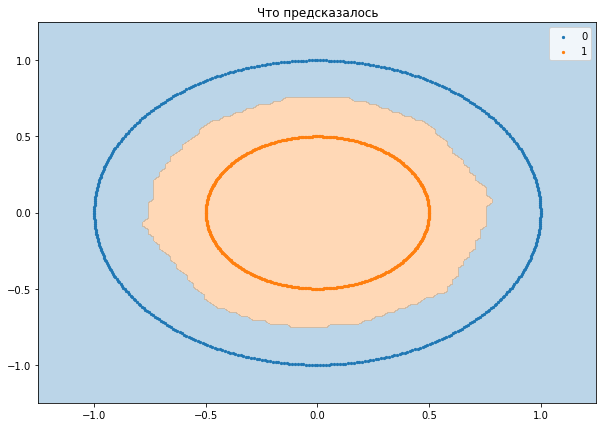

In [49]:
np.random.seed(42)
dataset = make_circles(1000, factor=0.5, random_state=42)

X = dataset[0]
y = dataset[1]

model = Sequential(
    Linear(2, 20),
    ReLU(),
    Linear(20, 10),
    ReLU(),
    Linear(10, 4),
    ReLU(),
    Linear(4, 1)
)

optimizer = Adam(model.parameters(), 0.01, alpha2=0.01)

for epoch in range(150):
    out = model.forward(X)

    loss = mse_loss(out, y.reshape((-1, 1)))
    #print(loss.item())

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

visualize_cls_preds(X, model)

Во втором случае тоже

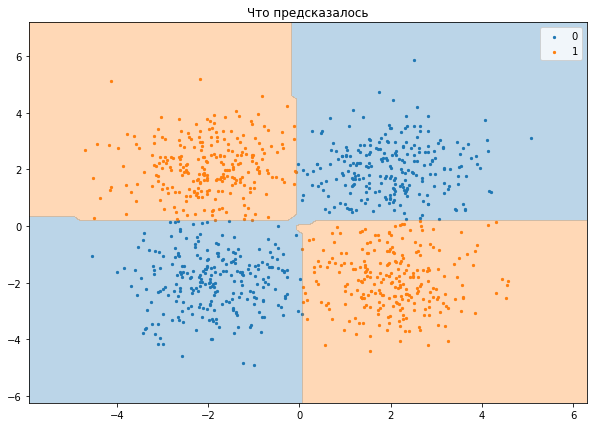

In [50]:
np.random.seed(42)
dataset = make_blobs(1000, 2, centers=[
                                       [2, 2], [2, -2],
                                       [-2, -2], [-2, 2]
], random_state=42)

X = dataset[0]
y = dataset[1]
y = y % 2

model = Sequential(
    Linear(2, 20),
    ReLU(),
    Linear(20, 10),
    ReLU(),
    Linear(10, 4),
    ReLU(),
    Linear(4, 1)
)

optimizer = Adam(model.parameters(), 0.01, alpha2=0.01)

for epoch in range(150):
    out = model.forward(X)

    loss = mse_loss(out, y.reshape((-1, 1)))
    #print(loss.item())

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

visualize_cls_preds(X, model)

### Batch norm

Сначала необходимо посчитать среднее по бачу и дисперсию по бачу по каждому параметру, а затем пересчитать значения параметров

$$\hat{x}_k = \frac{x_k - \mathbb{E}x_k}{\sqrt{\sigma^2(x_k)+\epsilon}},$$

после чего посчитать выход слоя $y_k$

$$y_k = \gamma_k\hat{x}_k+\beta_k,$$

где $\gamma_k$ и $\beta_k$ обучаемые параметры модели.

Аналогично реализованному в [pythorch](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html), мы будем использовать момент для наращивания средних значений. То есть для обновления статистики $\hat{z}_k$ мы будем использовать приближение

$$\hat{z}_{k, new} = (1-\text{momentum})\cdot \hat{z}_k + \text{momentum}\cdot z_k$$

Эти статистики будут использоваться далее на этапе оценки.

Разберемся с градиентами. Для градиентов по $\gamma$ и $\beta$ все аналогично линейному случаю, причем для $\beta$ формула такая же:

$$grad_{\beta} = \sum_{i=1}^M grad_{out, i}$$

Для $\gamma$ все немного иначе, так как у нас здесь поэлементное умножение $\gamma$ и $\hat{x}$, то индексируя элемент бача вторым числом

$$\frac{\partial y_{k, i}}{\partial \gamma_{l}} = \delta_{k,l} \hat{x}_{k,i}$$

Поэтому

$$grad_{\gamma} = \sum_{i=1}^M \hat{x}_i\otimes grad_{out,i},$$

где $i$ индексирует элемент бача

Осталось посчитать градиент по входному вектору. Для этого немного распишем $y_k$

$$y_k = \gamma_k\hat{x}_k + \beta_k = \frac{\gamma_k}{\sqrt{\sigma^2(x_k)+\epsilon}}x_k - \frac{\gamma_k\mathbb{E}x_k}{\sqrt{\sigma^2(x_k)+\epsilon}} + \beta_k$$

$$\frac{\partial y_{k,i}}{\partial x_{l, j}} = \delta_{k,l}\delta_{i,j} \frac{\gamma_k}{\sqrt{\sigma^2(x_k)+\epsilon}}$$

То есть просто градиент нужно умножить поэлементно на $\gamma/\sqrt{\sigma^2(x)+\epsilon}$

In [51]:
class BatchNorm:
    """Реализует Batch norm
    
    ---------
    Параметры
    ---------
    in_dim : int
        Размерность входного вектора

    eps : float (default=1e-5)
        Параметр модели, 
        позволяет избежать деления на 0

    momentum : float (default=0.1)
        Параметр модели
        Используется для обновления статистик
    """
    def __init__(self, in_dim, eps=1e-5, momentum=0.1):
        self.in_dim = in_dim
        self.eps = eps
        self.momentum = 0.1

        self.regime = "Train"

        self.gamma = Parameters((in_dim, ))
        self.gamma._init_params()

        self.beta = Parameters(in_dim)

        self.E = np.zeros(in_dim)
        self.D = np.zeros(in_dim)

        self.inpt_hat = None
        self.tmp_D = None

    def forward(self, inpt):
        """Реализует forward-pass

        ---------
        Параметры
        ---------
        inpt : np.ndarray, shape=(M, N_in)
            Входные данные

        ----------
        Возвращает
        ----------
        output : np.ndarray, shape=(M, N_in)
            Выход слоя
        """
        if self.regime == "Eval":
            inpt_hat = (inpt - self.E) / np.sqrt(self.D + self.eps)
            out =  self.gamma.params * inpt_hat + self.beta.params
            return out

        E = np.mean(inpt, axis=0)
        D = np.var(inpt, axis=0)

        self.E = (1 - self.momentum) * self.E + self.momentum * E
        self.D = (1 - self.momentum) * self.D + self.momentum * D
        
        inpt_hat = (inpt - E) / np.sqrt(D + self.eps)

        self.tmp_D = D
        self.inpt_hat = inpt_hat

        out = self.gamma.params * inpt_hat + self.beta.params

        return out

    def __call__(self, *inpt):
        """Аналогично forward"""
        return self.forward(*inpt)

    def parameters(self):
        """Возвращает параметры модели"""
        return (self.gamma, self.beta)

    def _zero_grad(self):
        """Обнуляет градиенты модели"""
        self.gamma.grads = np.zeros(self.gamma.shape)
        self.beta.grads = np.zeros(self.beta.shape)

    def _compute_gradients(self, grads):
        """Считает градиенты модели"""
        if self.regime == "Eval":
            raise RuntimeError("Нельзя посчитать градиенты в режиме оценки")
        
        self.beta.grads = self.beta.grads + grads.sum(axis=0)
        x_hat_mult_grads = np.multiply(self.inpt_hat, grads)
        self.gamma.grads = self.gamma.grads + x_hat_mult_grads.sum(axis=0)

        return grads * (self.gamma.params / np.sqrt(self.tmp_D + self.eps))

    def _train(self):
        """Переводит модель в режим обучения"""
        self.regime = "Train"

    def _eval(self):
        """Переводит модель в режим оценивания"""
        self.regime = "Eval"

    def __repr__(self):
        return f"BatchNorm(in_dim={self.in_dim}, eps={self.eps})"

#### Проверка работоспособности

Посмотрим на наши датасеты

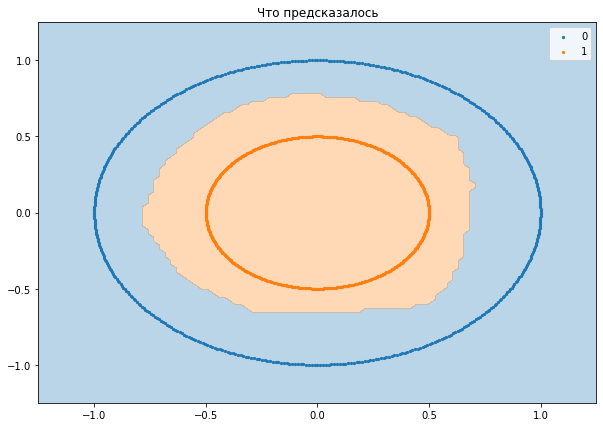

In [52]:
np.random.seed(42)
dataset = make_circles(1000, factor=0.5, random_state=42)

X = dataset[0]
y = dataset[1]

model = Sequential(
    Linear(2, 20),
    ReLU(),
    BatchNorm(20),
    Linear(20, 10),
    ReLU(),
    BatchNorm(10),
    Linear(10, 4),
    ReLU(),
    BatchNorm(4),
    Linear(4, 1)
)

optimizer = Adam(model.parameters(), 0.01)

for epoch in range(100):
    model.train()
    out = model.forward(X)

    loss = mse_loss(out, y.reshape((-1, 1)))
    #print(loss.item())

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

model.eval()
visualize_cls_preds(X, model)

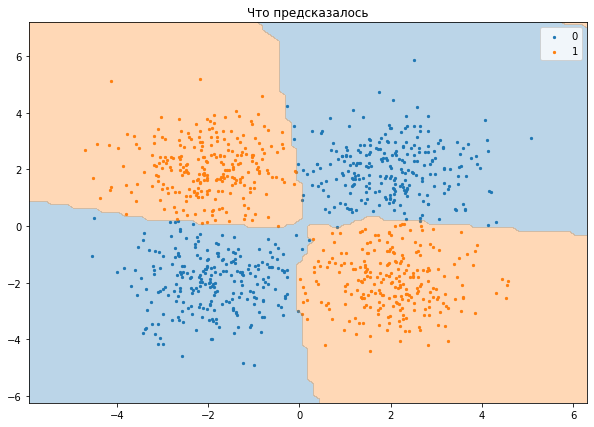

In [53]:
np.random.seed(42)
dataset = make_blobs(1000, 2, centers=[
                                       [2, 2], [2, -2],
                                       [-2, -2], [-2, 2]
], random_state=42)

X = dataset[0]
y = dataset[1]
y = y % 2

model = Sequential(
    Linear(2, 20),
    ReLU(),
    BatchNorm(20),
    Linear(20, 10),
    ReLU(),
    BatchNorm(10),
    Linear(10, 4),
    ReLU(),
    BatchNorm(4),
    Linear(4, 1)
)

optimizer = Adam(model.parameters(), 0.01)

for epoch in range(100):
    model.train()
    out = model.forward(X)

    loss = mse_loss(out, y.reshape((-1, 1)))
    #print(loss.item())

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

model.eval()
visualize_cls_preds(X, model)

Видим, что все предсказалось нормально, значит слой реализован верно

# Исследование и работа с CIFAR-10

## Загрузка данных

Скачаем датасет

In [54]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2022-04-02 07:03:16--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  69.6MB/s    in 2.3s    

2022-04-02 07:03:18 (69.6 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



И распакуем его

In [55]:
!tar -xzf cifar-10-python.tar.gz

На выходе будем иметь следующие файлы

In [56]:
files = glob.glob("cifar-10-batches-py/**")
files = [item.split('/')[-1] for item in files]
for file in sorted(files):
    print(f"-{file}")

-batches.meta
-data_batch_1
-data_batch_2
-data_batch_3
-data_batch_4
-data_batch_5
-readme.html
-test_batch


Из этих файлов нас интересуют data_batch_1, data_batch_2, ..., data_batch_5 -- это файлы с тренировочными данными, и файл test_batch -- это файл с тестовыми данными, на которых мы будем измерять свои метрики.

Посмотрим ближе на структуру файлов

In [57]:
with open("cifar-10-batches-py/data_batch_1", "rb") as f:
    train_dataset_1 = pickle.load(f, encoding="bytes")

Датасет содержит следующие ключи:

In [58]:
for key in train_dataset_1.keys():
    print(f"-{key.decode('utf-8')}")

-batch_label
-labels
-data
-filenames


Ключ `batch_label` нас не интересует, так как содержит только лишь информацию о номере бача

In [59]:
train_dataset_1[b'batch_label'].decode('utf-8')

'training batch 1 of 5'

Ключ `filenames` в данном случае нас тоже не интересует, так как он содержит названия файлов, которые мы без привлечения языковых моделей использовать не сможем

In [60]:
print("Первые 10 названий:")
for name in train_dataset_1[b'filenames'][:10]:
    print(f"-{name.decode('utf-8')}")

Первые 10 названий:
-leptodactylus_pentadactylus_s_000004.png
-camion_s_000148.png
-tipper_truck_s_001250.png
-american_elk_s_001521.png
-station_wagon_s_000293.png
-coupe_s_001735.png
-cassowary_s_001300.png
-cow_pony_s_001168.png
-sea_boat_s_001584.png
-tabby_s_001355.png


Остаются два наиболее интересных ключа, это `data` и `labels`.

Как нетрудно догадаться, `labels` содержит классы. Выведем первые 10 элементов:

In [61]:
print(train_dataset_1[b'labels'][:10])

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]


Классы представлены числовыми метками. В принципе нам нет необходимости знать соответствие между ними, однако эти данные можно найти в файле `batches.meta`:

In [62]:
with open("cifar-10-batches-py/batches.meta", "rb") as f:
    classes_names = pickle.load(f, encoding="bytes")

for ind, name in enumerate(classes_names[b'label_names']):
    print(f"{ind}: {name.decode('utf-8')}")

0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck


Ключ `data` содержит уже сами числовые данные

In [63]:
print(f"Количество данных: {len(train_dataset_1[b'data'])}")
print(f"Размер вектора: {train_dataset_1[b'data'][0].shape}")

Количество данных: 10000
Размер вектора: (3072,)


Теперь интересно посмотреть на сбалансированность меток по разбиениям. Для этого загрузим все тестовые разбиения

In [64]:
with open("cifar-10-batches-py/data_batch_2", "rb") as f:
    train_dataset_2 = pickle.load(f, encoding="bytes")

with open("cifar-10-batches-py/data_batch_3", "rb") as f:
    train_dataset_3 = pickle.load(f, encoding="bytes")

with open("cifar-10-batches-py/data_batch_4", "rb") as f:
    train_dataset_4 = pickle.load(f, encoding="bytes")

with open("cifar-10-batches-py/data_batch_5", "rb") as f:
    train_dataset_5 = pickle.load(f, encoding="bytes")

И посчитаем скаолько раз каждая метка встречается в каждом датасете

In [65]:
datasets = [train_dataset_1, train_dataset_2, train_dataset_3, 
            train_dataset_4, train_dataset_5]

labels = list(range(10))

print("|=====|{}|{}|{}|{}|{}|{}|".format(
    "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6))
print("|Label|{0:^{1}}|{2:^{3}}|{4:^{5}}|{6:^{7}}|{8:^{9}}|{10:^{11}}|".format(
    "Data 1", 6, "Data 2", 6, "Data 3", 6, "Data 4", 6, "Data 5", 6, "Sum", 6))
print("|=====|{}|{}|{}|{}|{}|{}|".format(
    "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6))

for label in labels:
    print("|{0:^{1}}|".format(label, 5), end='')
    label_num = 0
    for dataset in datasets:
        print("{0:^{1}}|".format(dataset[b'labels'].count(label), 6), end='')
        label_num += dataset[b'labels'].count(label)
    print("{0:^{1}}|".format(label_num, 6))

print("|=====|{}|{}|{}|{}|{}|{}|".format(
    "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6))

|=====|======|======|======|======|======|======|
|Label|Data 1|Data 2|Data 3|Data 4|Data 5| Sum  |
|=====|======|======|======|======|======|======|
|  0  | 1005 | 984  | 994  | 1003 | 1014 | 5000 |
|  1  | 974  | 1007 | 1042 | 963  | 1014 | 5000 |
|  2  | 1032 | 1010 | 965  | 1041 | 952  | 5000 |
|  3  | 1016 | 995  | 997  | 976  | 1016 | 5000 |
|  4  | 999  | 1010 | 990  | 1004 | 997  | 5000 |
|  5  | 937  | 988  | 1029 | 1021 | 1025 | 5000 |
|  6  | 1030 | 1008 | 978  | 1004 | 980  | 5000 |
|  7  | 1001 | 1026 | 1015 | 981  | 977  | 5000 |
|  8  | 1025 | 987  | 961  | 1024 | 1003 | 5000 |
|  9  | 981  | 985  | 1029 | 983  | 1022 | 5000 |
|=====|======|======|======|======|======|======|


Как видим, данные не сбалансированы по разбиениям, поэтому объединим все в один датасет и разобьем это на два датасета, тренировочный и валидационный, при этом сразу поделим значения каждого вектора на 256, чтобы иметь интенсивность в относительных единицах (хотя максимум на 255)

In [66]:
train_dataset = []

for dataset in datasets:
    for vec, label in zip(dataset[b'data'], dataset[b'labels']):
        train_dataset.append((vec / 256, label))

На валидационную выборку оставим 10000 элементов, по 1000 примеров из каждого класса, выбранных случайно

In [67]:
np.random.seed(42)
np.random.shuffle(train_dataset)

train_data = []
valid_data = []

cnt = {ind: 0 for ind in range(10)}

for vec, label in train_dataset:
    if cnt[label] < 1000:
        cnt[label] += 1
        valid_data.append((vec, label))
    else:
        train_data.append((vec, label))

Подготовим еще тестовый датасет

In [68]:
with open("cifar-10-batches-py/test_batch", "rb") as f:
    test_dataset = pickle.load(f, encoding="bytes")

test_data = []
for vec, label in zip(test_dataset[b'data'], test_dataset[b'labels']):
    test_data.append((vec / 256, label))

Посмотрим на статистики

In [69]:
print("|=====|{}|{}|{}|{}|".format("=" * 6, "=" * 6, "=" * 6, "=" * 6))
print("|Label|{0:^{1}}|{2:^{3}}|{4:^{5}}|{6:^{7}}|".format(
    "Train", 6, "Valid", 6, "Test", 6, "Sum", 6))
print("|=====|{}|{}|{}|{}|".format("=" * 6, "=" * 6, "=" * 6, "=" * 6))

labels = list(range(10))
for label in labels:
    print("|{0:^{1}}|".format(label, 5), end='')
    label_num = 0
    for dataset in (train_data, valid_data, test_data):
        labels_data = [item[1] for item in dataset]
        print("{0:^{1}}|".format(labels_data.count(label), 6), end='')
        label_num += labels_data.count(label)
    print("{0:^{1}}|".format(label_num, 6))

print("|=====|{}|{}|{}|{}|".format("=" * 6, "=" * 6, "=" * 6, "=" * 6))

|=====|======|======|======|======|
|Label|Train |Valid | Test | Sum  |
|=====|======|======|======|======|
|  0  | 4000 | 1000 | 1000 | 6000 |
|  1  | 4000 | 1000 | 1000 | 6000 |
|  2  | 4000 | 1000 | 1000 | 6000 |
|  3  | 4000 | 1000 | 1000 | 6000 |
|  4  | 4000 | 1000 | 1000 | 6000 |
|  5  | 4000 | 1000 | 1000 | 6000 |
|  6  | 4000 | 1000 | 1000 | 6000 |
|  7  | 4000 | 1000 | 1000 | 6000 |
|  8  | 4000 | 1000 | 1000 | 6000 |
|  9  | 4000 | 1000 | 1000 | 6000 |
|=====|======|======|======|======|


## Загрузчики данных

Итак, все разбито на нужные части, осталось подготовить загрузчик данных. Загружать будем порциями по 1000 элементов

In [70]:
class Dataloader:
    """Загрузчик данных

    ---------
    Параметры
    ---------
    dataset : list
        Датасет, состоящий из пар (вектор, метка)

    batch_size : int (default=1000)
        Размер бача

    is_train : bool (default=True)
        Если True, перед выдачей перемешивает датасет
        Если False, то не перемешивает
    """
    def __init__(self, dataset, batch_size=1000, is_train=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.is_train = is_train
        self.array = list(range(len(self.dataset)))

        if is_train:
            np.random.shuffle(self.array)

    def __iter__(self):
        return self

    def __len__(self):
        return int(np.ceil(len(self.dataset) / self.batch_size))

    def __next__(self):
        if len(self.array) == 0:
            raise StopIteration()

        if len(self.array) > self.batch_size:
            selected = self.array[:self.batch_size]
            self.array = self.array[self.batch_size:]
        else:
            selected = self.array[:]
            self.array = []

        data = []
        labels = []
        for ind in selected:
            data.append(self.dataset[ind][0])
            labels.append(self.dataset[ind][1])

        return np.array(data), labels

## Функции для обучения

Воспользуемся самописными функциями для отображения прогресса обучения

In [71]:
def progress_bar(iterable, text='Epoch progress', end=''):
    """Мониториг выполнения эпохи
    
    ---------
    Параметры
    ---------
    iterable
        Что-то по чему можно итерироваться
        
    text: str (default='Epoch progress')
        Текст, выводящийся в начале
        
    end : str (default='')
        Что вывести в конце выполнения
    """
    max_num = len(iterable)
    iterable = iter(iterable)
    
    start_time = time.time()
    cur_time = 0
    approx_time = 0
    
    print('\r', end='')
    
    it = 0
    while it < max_num:
        it += 1
        print(f"{text}: [", end='')

        progress = int((it - 1) / max_num * 50)
        print('=' * progress, end='')
        if progress != 50:
            print('>', end='')
            print(' ' * (50 - progress - 1), end='')
        print('] ', end='')
        
        print(f'{it-1}/{max_num}', end='')
        print(' ', end='')
        
        print(f'{cur_time}s>{approx_time}s', end='')
        
        yield next(iterable)
        
        print('\r', end='')
        print(' ' * (60 + len(text) + len(str(max_num)) + len(str(it)) \
                  + len(str(cur_time)) + len(str(approx_time))), 
              end='')
        print('\r', end='')

        cur_time = time.time() - start_time
        
        approx_time = int(cur_time / it * (max_num - it))
        cur_time = int(cur_time)
        print(end, end='')

In [72]:
class EpochInformation:
    """Выдает информацию об эпохе
    
    ---------
    Параметры
    ---------
    max_num : int
        Максимальное число эпох
    
    description : list
        Список, каждый элемент которого представляет собой кортеж:
        * первый элемент содержит название параметра
        * второй элемент определяет максимальное число символов в строке
          если это число меньше длины названия, берется длина названия
          если в строчку не помещается описание величины,
          все доступные символы заменятся на символы '?'
        * третий элемент (необязателен) определяет число знаков
          после запятой для вещественных чисел
    """
    def __init__(self, max_num, description):
        self.max_num = max_num
        self.description = description
        self.iteration = 0
        
        for ind in range(len(description)):
            info = description[ind]
            if len(info[0]) > info[1]:
                if len(info) == 2:
                    self.description[ind] = (info[0], len(info[0]))
                else:
                    self.description[ind] = (info[0], len(info[0]), info[2])
                    
        print('|{0:^{1}}|'.format('Epoch', 
                                  max(5, 1 + 2 * len(str(max_num)))), 
              end='')
        
        for info in self.description:
            print('{0:^{1}}|'.format(info[0], info[1]), end='')
        
        print()
        
        print('|{0:=>{1}}|'.format('', max(5, 1 + 2 * len(str(max_num)))),
              end='')
        for info in self.description:
            print('{0:=>{1}}|'.format('', info[1]), end='')
        
        print()
            
            
    def update(self, values, step=1):
        """Выводит параметры для следующей эпохи
        
        ---------
        Параметры
        ---------
        values : dict
            Словарь, в котором ключи - это названия из description,
            а значения - это то, что нужно вписать в ячейку
            
        step : int (default=1)
            Количество сделанных итераций с последнего вызова
        """
        self.iteration += step
        
        print('|{0:>{1}}/{2}|'.format(self.iteration, 
                                      max(4 - len(str(self.max_num)), 
                                          len(str(self.max_num))),
                                      self.max_num), end='')
        
        for info in self.description:
            if len(info) == 2:
                string = str(values[info[0]])
            else:
                string = '{0:.{1}f}'.format(values[info[0]], info[2])
                
            if len(string) > info[1]:
                string = '?' * info[1]
            
            print('{0:^{1}}|'.format(string, info[1]), end='')
            
        print()

In [73]:
def train(dataset, model, epochs=100, lr=1e-3, batch_size=1000, 
          valid_dataset=None, timer=True, return_history=True, step=1,
          visualize_train=True, optim_method="Adam", alpha1=None, alpha2=None):
    """Тренирует модель
    
    dataset
        Массив данных для обучения
        
    model
        Модель, которую будем обучать
        
    epochs : int (default=100)
        Число эпох
        
    lr : float (default=1e-4)
        Learning rate
        
    batch_size : int (default=1000)
        Размер бача
        Если парамтр равен -1, то берутся все данные
        
    valid_dataset (default=None)
        Массив данных для валидации
        Если установлен в None, оценки на валидационной выборке нет
        
    timer : bool (default=True)
        Если установлен в True будет выводить сколько времени заняло 
        обучение на данной эпохе
        
    return_history : bool (default=True)
        Если установлен в True, вернет историю изменений ошибки
        
    step : int (default=1)
        Число итераций, через которое вычисляются ошибки
        
    visualize_train : bool (default=True)
        Визуализировать ли метрики во время обучения

    optim_method : str (default=Adam)
        Метод оптимизации, доступны
        * "Adam" -- алгоритм Adam
        * "GD" -- градиентный спуск
        
    alpha1 : float (default=None)
        Если не None, то применяет l_1 регуляризацию
        с параметром alpha_1

    alpha2 : float (default=None)
        Если не None, то применяет l_2 регуляризацию
        с параметром alpha_2
    ----------
    Возвращает
    ----------
    * Если return_history=True и valid_dataset не None
        train_loss_history : list
            История ошибок на обучающей выборке
        
        valid_loss_history : list
            История ошибок на валидационной выборке
            
        train_acc_history : list
            История точности предсказания на обучающей выборке
        
        valid_acc_history : list
            История точности предсказания на валидационной выборке
            
    * Если return_history=True и valid_dataset=None
        train_loss_history : list
            История ошибок на обучающей выборке
            
        train_acc_history : list
            История точности предсказания на обучающей выборке
            
    * Если return_history=False
        None
    """
    if timer:
        start_time = time.time()
    
    if optim_method == "Adam":
        optimizer = Adam(model.parameters(), lr=lr,
                         alpha1=alpha1, alpha2=alpha2)
    elif optim_method == "GD":
        optimizer = GD(model.parameters(), lr=lr,
                       alpha1=alpha1, alpha2=alpha2)
    
    if return_history:
        train_loss_history = []
        train_acc_history = []
        if valid_dataset:
            valid_loss_history = []
            valid_acc_history = []

    description = [('Train loss', 0, 4)]
    description.append(('Train acc', 0, 4))

    if valid_dataset:
        description.append(('Valid loss', 0, 4))
        description.append(('Valid acc', 0, 4))

    description.append(('Grad/W', 10, 6))

    if timer:
        description.append(('Time, s', 10, 1))
        description.append(('Total, s', 10, 1))

    if visualize_train:
        epoch_logger = EpochInformation(epochs, description)

    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()
        dataloader = Dataloader(dataset, batch_size=batch_size)
        for vecs, labels in progress_bar(dataloader):
            out = model.forward(vecs)

            loss = hinge_loss(out, labels)
            model.zero_grad()
            loss.backward()

            optimizer.step()
        
        if (epoch + 1) % step == 0 or (epoch + 1) == epochs:
            if (epoch + 1) == epochs and ((epoch + 1) % step != 0):
                step = (epoch + 1) % step
            values = {}

            model.eval()
            
            dataloader = Dataloader(dataset, batch_size=len(dataset), 
                                    is_train=False)
            
            for vecs, labels in progress_bar(dataloader, 
                                             text='Evaluating train'):
                out = model.forward(vecs)

                loss = hinge_loss(out, labels)
                train_loss = loss.item()

                pred_labels = np.argmax(out.array, axis=-1)
                train_acc = np.sum(pred_labels == labels) / len(labels)
            
            values['Train loss'] = train_loss
            values['Train acc'] = train_acc

            num_params = 0
            scale = 0

            for param in model.parameters():
                param_norm = np.linalg.norm(param.params.flatten())
                if param_norm == 0.:
                    continue
                else:
                    num_params += 1
                    grad_norm = np.linalg.norm(param.grads.flatten())
                    scale += lr * grad_norm / param_norm

            scale /= num_params

            values['Grad/W'] = scale

            if return_history:
                train_loss_history.append(train_loss)
                train_acc_history.append(train_acc)

            if valid_dataset:
                
                valid_dataloader = Dataloader(valid_dataset, 
                                              batch_size=len(valid_dataset), 
                                              is_train=False)
                
                for vecs, labels in progress_bar(valid_dataloader, 
                                                 text='Evaluating valid'):
                    out = model.forward(vecs)

                    loss = hinge_loss(out, labels)
                    valid_loss = loss.item()

                    pred_labels = np.argmax(out.array, axis=-1)
                    valid_acc = np.sum(pred_labels == labels) / len(labels)

                values['Valid loss'] = valid_loss
                values['Valid acc'] = valid_acc

                if return_history:
                    valid_loss_history.append(valid_loss)
                    valid_acc_history.append(valid_acc)

            if timer:
                values['Time, s'] = time.time() - epoch_start_time
                values['Total, s'] = time.time() - start_time
            
            if visualize_train:
                epoch_logger.update(values, step)

    if return_history:
        if valid_dataset:
            return train_loss_history, valid_loss_history, \
                   train_acc_history, valid_acc_history
        else:
            return train_loss_history, train_acc_history
    else:
        return None

## Обучение

Перед обучением отнормируем все данные

In [74]:
train_matrix = np.array([item[0] for item in train_data])
D = np.var(train_matrix, axis=0)
E = np.mean(train_matrix, axis=0)

for ind in range(len(train_data)):
    train_data[ind] = (train_data[ind][0] - E, train_data[ind][1])
    train_data[ind] = (train_data[ind][0] / np.sqrt(D), train_data[ind][1])

for ind in range(len(valid_data)):
    valid_data[ind] = (valid_data[ind][0] - E, valid_data[ind][1])
    valid_data[ind] = (valid_data[ind][0] / np.sqrt(D), valid_data[ind][1])

for ind in range(len(test_data)):
    test_data[ind] = (test_data[ind][0] - E, test_data[ind][1])
    test_data[ind] = (test_data[ind][0] / np.sqrt(D), test_data[ind][1])

Возьмем небольшую сеть и посмотрим на ней качество, будем использовать далее его в качестве референса

In [75]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)
model

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 128, bias=True),
	ReLU(),
	Linear(128, 10, bias=True)
)

Запустим обучение, чтобы проверить, что модель хотя бы как-то работает. Запустим на 10 эпохах.

In [76]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  4.1859  | 0.2228  |  4.2547  | 0.2198  | 0.009321 |   35.6   |   35.6   |
| 2/10|  2.5723  | 0.2559  |  2.5680  | 0.2497  | 0.006326 |   33.5   |   69.1   |
| 3/10|  2.1379  | 0.3210  |  2.1715  | 0.3134  | 0.003249 |   43.3   |  112.4   |
| 4/10|  1.6925  | 0.3070  |  1.7188  | 0.3051  | 0.002533 |   38.5   |  150.9   |
| 5/10|  1.5060  | 0.3503  |  1.5335  | 0.3377  | 0.002016 |   28.1   |  179.0   |
| 6/10|  1.3573  | 0.3595  |  1.3994  | 0.3406  | 0.002390 |   28.7   |  207.8   |
| 7/10|  1.2702  | 0.3710  |  1.3206  | 0.3467  | 0.001495 |   28.9   |  236.7   |
| 8/10|  1.2254  | 0.3808  |  1.2722  | 0.3578  | 0.001483 |   28.3   |  264.9   |
| 9/10|  1.1728  | 0.4038  |  1.2263  | 0.3708  | 0.001121 |   28.7   |  293.7   |
|10/10|  1.1318  | 0.4156  |  1.1929  | 0.3747  | 0.001342 |   28.3   |  322.0   |


Модель выдает достаточно приемлемое качество. Изобразим кривые обучения

In [77]:
def plot_learning_curves(train_loss_history, valid_loss_history, 
                         train_acc_history, valid_acc_history):
    """Строит графики качества на предсказании модели

    ---------
    Параметры
    ---------
    train_loss_history : list
        История ошибки на тренировочной выборке

    valid_loss_history : list
        История ошибки на валидационной выборке

    train_acc_history : list
        История точности на тренировочной выборке

    valid_acc_history : list
        История точности на валидационной выборке
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(list(range(1, 1 + len(train_loss_history))),
                 train_loss_history, c='tab:blue', label="Train")
    axes[0].plot(list(range(1, 1 + len(train_loss_history))),
                 valid_loss_history, c='tab:orange', label="Valid")
    
    axes[1].plot(list(range(1, 1 + len(train_acc_history))),
                 train_acc_history, c='tab:blue', label="Train")
    axes[1].plot(list(range(1, 1 + len(train_acc_history))),
                 valid_acc_history, c='tab:orange', label="Valid")

    axes[0].set_xlabel("Эпоха")
    axes[1].set_xlabel("Эпоха")

    axes[0].set_ylabel("Ошибка")
    axes[1].set_ylabel("Точность")

    axes[0].set_title("История ошибки")
    axes[1].set_title("История точности")

    axes[0].grid(ls=':')
    axes[1].grid(ls=':')

    axes[0].legend()
    axes[1].legend()
    
    plt.show()

Изобразим графики обучения

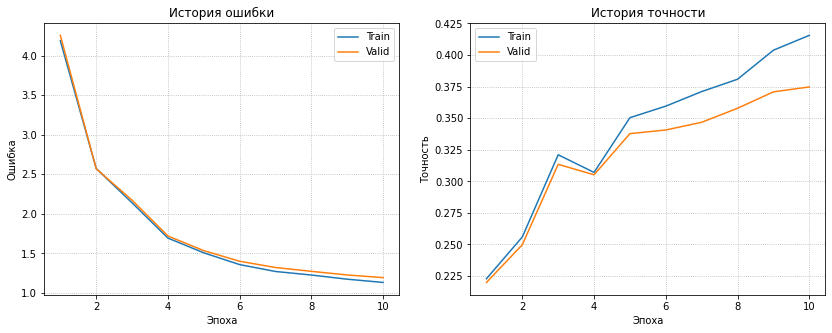

In [78]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

Модель явно не достигла своего максимума по качеству

Оценим качество на тествовой выборке

In [79]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.1932
Точность на тесте: 0.3780


А также приведем classification report (реализация из sklearn)

In [80]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.53      0.34      0.41      1000
           1       0.50      0.47      0.48      1000
           2       0.31      0.18      0.23      1000
           3       0.23      0.40      0.29      1000
           4       0.31      0.30      0.31      1000
           5       0.30      0.28      0.29      1000
           6       0.38      0.37      0.37      1000
           7       0.44      0.36      0.40      1000
           8       0.47      0.61      0.53      1000
           9       0.42      0.47      0.45      1000

    accuracy                           0.38     10000
   macro avg       0.39      0.38      0.38     10000
weighted avg       0.39      0.38      0.38     10000



Самое низкое качество по precision у котов, то есть модель слишком часто предсказывает котов, чем следовало бы. Самое низкое качество в принципе и по recall у птиц, то есть модель не научилась хорошо определять птиц.

Лучшее качество по precision (хотя recall далеко не самый высокий) у самолетов, а лучшее качество по recall (и в принципе самое высокое) у кораблей.

Таким образом, технику модель определяет лучше, чем живых существ.

## Изучение свойств дополнительных слоев

### ReLU, Sigmoid, Tanh

Как мы выяснили с первого прогона модели, 10 эпох недостаточно, нужно больше. Поэтому далее будет браться по 20 эпох.

Для того, чтобы сравнить все эти три функции активации, нужно для одной модели использовать все три функции и сравнить результаты. Пока что модель оставим неизменной.

Начнем с ReLU

In [81]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=20,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/20|  4.1859  | 0.2228  |  4.2547  | 0.2198  | 0.009321 |   30.3   |   30.3   |
| 2/20|  2.5723  | 0.2559  |  2.5680  | 0.2497  | 0.006326 |   30.9   |   61.2   |
| 3/20|  2.1379  | 0.3210  |  2.1715  | 0.3134  | 0.003249 |   30.2   |   91.4   |
| 4/20|  1.6925  | 0.3070  |  1.7188  | 0.3051  | 0.002533 |   30.1   |  121.5   |
| 5/20|  1.5060  | 0.3503  |  1.5335  | 0.3377  | 0.002016 |   28.5   |  149.9   |
| 6/20|  1.3573  | 0.3595  |  1.3994  | 0.3406  | 0.002390 |   28.5   |  178.4   |
| 7/20|  1.2702  | 0.3710  |  1.3206  | 0.3467  | 0.001495 |   28.2   |  206.7   |
| 8/20|  1.2254  | 0.3808  |  1.2722  | 0.3578  | 0.001483 |   28.6   |  235.2   |
| 9/20|  1.1728  | 0.4038  |  1.2263  | 0.3708  | 0.001121 |   28.3   |  263.5   |
|10/20|  1.1318  | 0.4156  |  1.1929  | 0.3747  | 0.001342 |   28.6   |  292.1   |
|11/

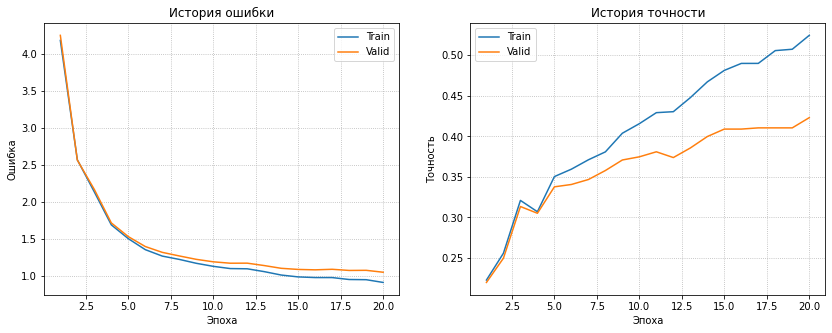

In [82]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [83]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.0510
Точность на тесте: 0.4248


In [84]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.53      0.55      0.54      1000
           1       0.50      0.59      0.54      1000
           2       0.30      0.22      0.25      1000
           3       0.27      0.23      0.25      1000
           4       0.36      0.28      0.32      1000
           5       0.32      0.34      0.33      1000
           6       0.42      0.46      0.43      1000
           7       0.42      0.50      0.46      1000
           8       0.53      0.62      0.57      1000
           9       0.49      0.47      0.48      1000

    accuracy                           0.42     10000
   macro avg       0.41      0.42      0.42     10000
weighted avg       0.41      0.42      0.42     10000



Теперь сигмоиду

In [85]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=20,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/20|  1.4029  | 0.2602  |  1.4122  | 0.2525  | 0.005855 |   29.8   |   29.8   |
| 2/20|  1.2953  | 0.3010  |  1.3009  | 0.2921  | 0.003319 |   29.7   |   59.6   |
| 3/20|  1.1962  | 0.3002  |  1.2037  | 0.2880  | 0.002259 |   29.8   |   89.3   |
| 4/20|  1.1509  | 0.3221  |  1.1562  | 0.3095  | 0.001684 |   32.3   |  121.6   |
| 5/20|  1.1239  | 0.3432  |  1.1288  | 0.3351  | 0.002279 |   31.0   |  152.6   |
| 6/20|  1.0969  | 0.3724  |  1.1028  | 0.3537  | 0.002652 |   30.1   |  182.7   |
| 7/20|  1.0832  | 0.3743  |  1.0910  | 0.3536  | 0.002004 |   30.1   |  212.9   |
| 8/20|  1.0648  | 0.3941  |  1.0736  | 0.3658  | 0.002034 |   30.2   |  243.0   |
| 9/20|  1.0543  | 0.4067  |  1.0629  | 0.3773  | 0.001175 |   30.1   |  273.1   |
|10/20|  1.0422  | 0.4189  |  1.0518  | 0.3868  | 0.000627 |   30.1   |  303.3   |
|11/

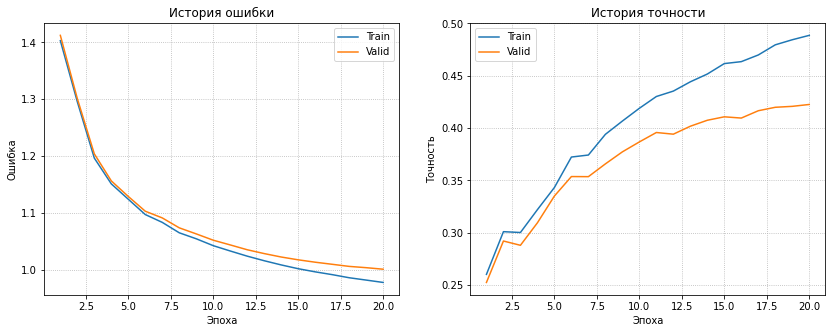

In [86]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [87]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 0.9992
Точность на тесте: 0.4289


In [88]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.49      0.54      0.51      1000
           1       0.44      0.58      0.50      1000
           2       0.38      0.18      0.25      1000
           3       0.29      0.15      0.20      1000
           4       0.38      0.32      0.34      1000
           5       0.37      0.35      0.36      1000
           6       0.43      0.52      0.47      1000
           7       0.41      0.55      0.47      1000
           8       0.49      0.68      0.57      1000
           9       0.48      0.43      0.46      1000

    accuracy                           0.43     10000
   macro avg       0.42      0.43      0.41     10000
weighted avg       0.42      0.43      0.41     10000



И наконец tanh

In [89]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    Tanh(),
    Linear(768, 128),
    Tanh(),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=20,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/20|  2.5505  | 0.2606  |  2.5652  | 0.2595  | 0.003143 |   39.0   |   39.0   |
| 2/20|  1.6803  | 0.2856  |  1.6955  | 0.2768  | 0.001424 |   30.0   |   69.1   |
| 3/20|  1.4604  | 0.2617  |  1.4733  | 0.2490  | 0.001017 |   30.1   |   99.2   |
| 4/20|  1.3856  | 0.2649  |  1.4001  | 0.2570  | 0.000365 |   34.9   |  134.1   |
| 5/20|  1.3420  | 0.2716  |  1.3606  | 0.2560  | 0.000367 |   30.0   |  164.1   |
| 6/20|  1.3084  | 0.2895  |  1.3333  | 0.2721  | 0.000323 |   30.1   |  194.2   |
| 7/20|  1.2897  | 0.2825  |  1.3215  | 0.2567  | 0.000277 |   30.0   |  224.2   |
| 8/20|  1.2729  | 0.2830  |  1.3137  | 0.2513  | 0.000362 |   30.1   |  254.3   |
| 9/20|  1.2559  | 0.2923  |  1.3052  | 0.2514  | 0.000265 |   30.2   |  284.5   |
|10/20|  1.2399  | 0.2922  |  1.2978  | 0.2450  | 0.000243 |   30.1   |  314.6   |
|11/

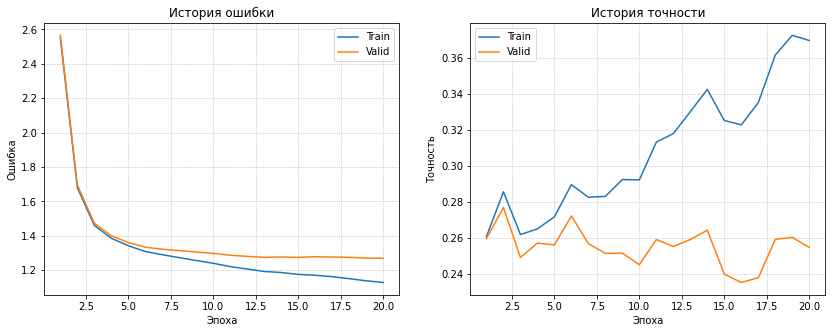

In [90]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [91]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.2749
Точность на тесте: 0.2566


In [92]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.25      0.10      0.15      1000
           1       0.32      0.39      0.35      1000
           2       0.17      0.11      0.13      1000
           3       0.15      0.28      0.20      1000
           4       0.20      0.23      0.21      1000
           5       0.30      0.20      0.24      1000
           6       0.34      0.21      0.26      1000
           7       0.20      0.36      0.26      1000
           8       0.47      0.38      0.42      1000
           9       0.38      0.29      0.33      1000

    accuracy                           0.26     10000
   macro avg       0.28      0.26      0.26     10000
weighted avg       0.28      0.26      0.26     10000



Сравним остальные с ReLU.

Хотя ReLU стартовала с более низкого качества по сравнению с сигмоидой, ее качество изменялось заметно быстрее и в итоге она достигла лучшего качества. Градиенты у сигмоиды остались в том же масштабе, хотя у ReLU они изменились довольно сильно.

Tanh показала себя хуже всех. Судя по кривым обучения на данном датасете мы достигли переобучения. Масштаб градиентов оказался наименьшим.

По времени все три модели показали себя одинаково.

А также рассмотрим большую сеть.

ReLU

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 1536),
    ReLU(),
    Linear(1536, 768),
    ReLU(),
    Linear(768, 384),
    ReLU(),
    Linear(384, 128),
    ReLU(),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=20,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/20|  4.0647  | 0.1660  |  4.1088  | 0.1633  | 0.009474 |   70.5   |   70.5   |
| 2/20|  2.5026  | 0.1988  |  2.5143  | 0.2003  | 0.009596 |   74.5   |  145.0   |
| 3/20|  1.9362  | 0.1868  |  1.9624  | 0.1830  | 0.006002 |   70.2   |  215.2   |
| 4/20|  1.6675  | 0.2386  |  1.6975  | 0.2299  | 0.004877 |   70.1   |  285.3   |
| 5/20|  1.4818  | 0.2742  |  1.5019  | 0.2706  | 0.003440 |   70.2   |  355.6   |
| 6/20|  1.3237  | 0.2977  |  1.3485  | 0.2828  | 0.002817 |   70.2   |  425.8   |
| 7/20|  1.1955  | 0.3320  |  1.2125  | 0.3170  | 0.001833 |   70.1   |  496.0   |
| 8/20|  1.1542  | 0.3429  |  1.1698  | 0.3270  | 0.001692 |   70.2   |  566.1   |
| 9/20|  1.1020  | 0.3562  |  1.1233  | 0.3386  | 0.001160 |   70.2   |  636.3   |
|10/20|  1.0962  | 0.3689  |  1.1186  | 0.3483  | 0.001325 |   73.7   |  710.0   |
|11/

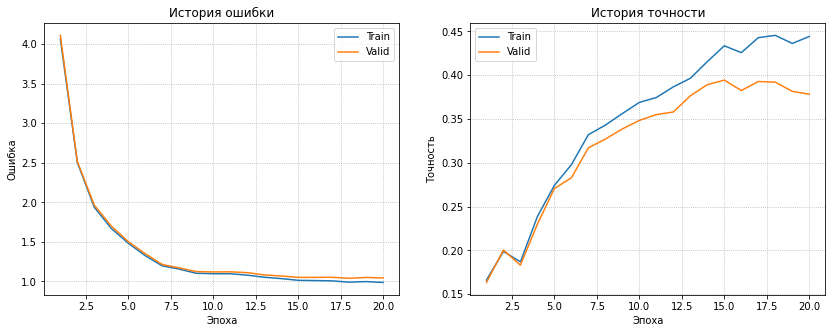

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.0351
Точность на тесте: 0.3893


In [ ]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.46      0.46      0.46      1000
           1       0.46      0.44      0.45      1000
           2       0.26      0.29      0.28      1000
           3       0.28      0.14      0.19      1000
           4       0.33      0.26      0.29      1000
           5       0.38      0.34      0.36      1000
           6       0.53      0.18      0.27      1000
           7       0.31      0.64      0.41      1000
           8       0.54      0.61      0.57      1000
           9       0.46      0.54      0.50      1000

    accuracy                           0.39     10000
   macro avg       0.40      0.39      0.38     10000
weighted avg       0.40      0.39      0.38     10000



Sigmoid

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 1536),
    Sigmoid(),
    Linear(1536, 768),
    Sigmoid(),
    Linear(768, 384),
    Sigmoid(),
    Linear(384, 128),
    Sigmoid(),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=20,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/20|  1.4408  | 0.1631  |  1.4409  | 0.1662  | 0.007280 |   75.6   |   75.6   |
| 2/20|  1.4313  | 0.1005  |  1.4314  | 0.1003  | 0.005565 |   75.5   |  151.1   |
| 3/20|  1.3829  | 0.1454  |  1.3832  | 0.1457  | 0.005246 |   75.4   |  226.5   |
| 4/20|  1.2468  | 0.1467  |  1.2473  | 0.1457  | 0.003879 |   75.4   |  301.9   |
| 5/20|  1.1679  | 0.1471  |  1.1684  | 0.1470  | 0.004650 |   75.2   |  377.1   |
| 6/20|  1.0973  | 0.1925  |  1.0980  | 0.1899  | 0.005302 |   75.4   |  452.6   |
| 7/20|  1.1062  | 0.1666  |  1.1066  | 0.1651  | 0.007515 |   81.1   |  533.7   |
| 8/20|  1.0882  | 0.2054  |  1.0885  | 0.2043  | 0.003848 |   75.3   |  609.0   |
| 9/20|  1.0535  | 0.2338  |  1.0541  | 0.2312  | 0.004837 |   75.8   |  684.7   |
|10/20|  1.0531  | 0.2422  |  1.0537  | 0.2356  | 0.003891 |   75.4   |  760.1   |
|11/

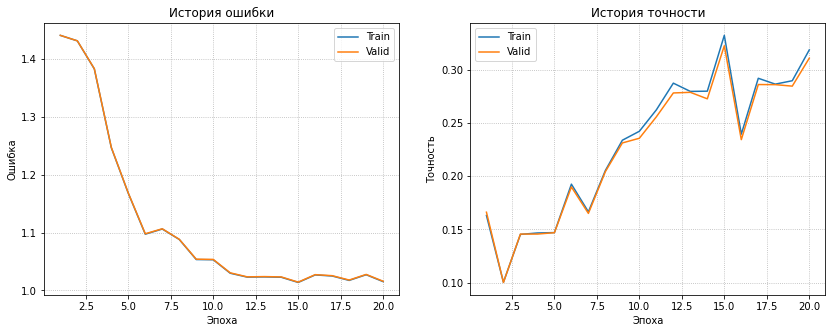

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.0154
Точность на тесте: 0.3183


In [ ]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.49      0.46      0.47      1000
           1       0.33      0.53      0.41      1000
           2       0.00      0.00      0.00      1000
           3       0.21      0.14      0.16      1000
           4       0.48      0.03      0.06      1000
           5       0.31      0.38      0.34      1000
           6       0.21      0.85      0.34      1000
           7       0.63      0.13      0.21      1000
           8       0.58      0.34      0.43      1000
           9       0.46      0.32      0.38      1000

    accuracy                           0.32     10000
   macro avg       0.37      0.32      0.28     10000
weighted avg       0.37      0.32      0.28     10000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Tanh

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 1536),
    Tanh(),
    Linear(1536, 768),
    Tanh(),
    Linear(768, 384),
    Tanh(),
    Linear(384, 128),
    Tanh(),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=20,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

Для данного случая по времени все модели отработали приблизительно одинаково.

ReLU показала себя лучше всех, она быстрее всех обучилась и на ней масштаб градиентов затух быстрее всего.

Сигмоида показала себя тоже достаточно достойно, однако она не предсказала отказалась предсказывать вторую метку, и в принципе показала сильно несбалансированное качество по классам.

Tanh очень быстро достиг оптимума, однако показал самое низкое качество, а также практически не смог предсказать 0, 1, 5 и 8 классы. Также у него самые низкие градиенты.

И еще возьмем совсем маленькую сеть

ReLU

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=20,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

Sigmoid

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=20,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

Tanh

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    Tanh(),
    Linear(768, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=20,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

ReLU достаточно быстро смогла достичь приемлего качества и дала сбаланстрованную оценку по качеству, градиенты затухли.

Сигмоида показала наиболее плавное поведение в смысле изменения ошибки, масштаб затуханий оказался тем же. На первой итерации сигмоида показала качество лучшее, чем ReLU. В среднем ReLU и сигмоида повели себя одинаково.

Tanh показала себя в принципе также как и остальные. Масштаб градиентов оказался ниже, чем у остальных.

Вывод таков, что на маленьких сетях нет принципиальной разницы, что использовать, на больших сетях ReLU ведет себя лучше остальных.

### Dropout

Возьмем среднюю сеть и посмотрим на поведение сети при установке $p=0.5$. Оставим ReLU.

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Dropout(0.5),
    Linear(768, 128),
    ReLU(),
    Dropout(0.5),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=20,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

Видно, что точность падает до 1, а модель предсказывает только один класс. Все дело в том, что learning rate стал слишком большой. Уменьшим его до 0.0001 и посмотрим на сеть еще раз (число эпох уменьшим до 10)

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Dropout(0.5),
    Linear(768, 128),
    ReLU(),
    Dropout(0.5),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=10,
    lr=0.0001,
    valid_dataset=valid_data,
    batch_size=10000)

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

Как видим, модель учится. Сравним с такой же моделью без Dropout

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=10,
    lr=0.0001,
    valid_dataset=valid_data,
    batch_size=10000)

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

Выводы: при использовании dropout уменьшается скорость роста функции. За одно и то же число итераций на тренировочной выборке без использования dropout достигается лучшее качество. Зато при использовании dropout кривые качества на тренировочной и валидационной выборке становятся значительно ближе, чем в том случае, если не использовать.

### L1

Попробуем нормализовать наши метрики с помощью L1 регуляризации. learning rate выставим равным 0.001.

Сначала посмотрим $\alpha_1=0.01$

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000,
    alpha1=0.01)

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

Видно, что по сравнению с [моделью](https://colab.research.google.com/drive/1I01jY7RFAR7APD0m-6lQG4oBrQQttK1P#scrollTo=jgfst1w3NmOl) без регуляризации кривые обучения и валидации стали значительно ближе, хотя скорость роста и точность предсказания модели упали

Если же взять слишком большое значение $\alpha_1=0.1$:

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000,
    alpha1=0.1)

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

Видно, что качество предсказания становится очень низким, практически случайным.

Посмотрим на норму весов модели

In [ ]:
print("Норма весов слоев:")
for module in model.modules:
    if isinstance(module, Linear):
        print(f"{str(module)}: {np.linalg.norm(module.W.params.flatten()):.2f}")

### L2

Попробуем нормализовать наши метрики с помощью L1 регуляризации. learning rate выставим равным 0.001.

Оптимальным является $\alpha_2=10$

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000,
    alpha2=10.)

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

Как видим, аналогично случаю с L1, кривые обучения на тренировочной и валидационной выборке начинают совпадать.

При уменьшении $\alpha_2$ ситуация становится более похожей на ситуацию без регуляризации

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000,
    alpha2=1.)

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

А при слишком большом значении параметра модель начинает выдавать бред

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000,
    alpha2=100.)

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

Посмотрим на веса модели

In [ ]:
print("Норма весов слоев:")
for module in model.modules:
    if isinstance(module, Linear):
        print(f"{str(module)}: {np.linalg.norm(module.W.params.flatten()):.2f}")

Для сравнения рассмотрим веса модели без регуляризации

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

In [ ]:
print("Норма весов слоев:")
for module in model.modules:
    if isinstance(module, Linear):
        print(f"{str(module)}: {np.linalg.norm(module.W.params.flatten()):.2f}")

Видно, что при регуляризации норма весов меньше, чем без нее

### Batch norm

Добавим к модели слои Batch norm и сравним модели

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    BatchNorm(768),
    ReLU(),
    Linear(768, 128),
    BatchNorm(128),
    ReLU(),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

Как видно, слой значительно замедляет обучение, тренировочная и валидационная кривая практически неразделимы, норма весов стала меньше

У нас очень плохо учился (и сильно переобучался) [пример](https://colab.research.google.com/drive/1I01jY7RFAR7APD0m-6lQG4oBrQQttK1P#scrollTo=STflxs3FO88u&line=1&uniqifier=1) с гиперболическим тангенсом. Попробуем это исправить, добавив слои Batch norm:

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    BatchNorm(768),
    Tanh(),
    Linear(768, 128),
    BatchNorm(128),
    Tanh(),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=20,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

Использование слоя действительно сильно помогло обучению, вполне вероятно прошлая инициализация весов была неудачной и привела к таким проблемам.

### Методы оптимизации

Методы оптимизации неоднократно исследовались в курсах оптимизации, поэтому пойду самым простым путем, рассмотрим наиболее простейший метод оптимизации (градиентный спуск) и использующийся сейчас повсеместно Adam (если не брать в расчет его модификации типа AdamW или NAdam). Adam я использовал везде до этого, теперь применю градиентный спуск

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=20,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000,
    optim_method="GD")

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

Видно, что использование ускоренных методов типа Adam сильно увеличивает скорость сходимости по сравнению с обычным градиентным спуском, однако требует в 3 раза больше памяти.

Помимо этого классический градиентный спуск ведет себя сильно плавнее, чем алгоритмы типа Adam.

В принципе используемых методов не то что бы очень много. AdaGrad, RMSProp, ... являются разновидностями Adam, если правильно настроить параметры. Из наиболее отличающихся стоит выделить SGD и метод Нестерова (экзотика не в счет). 

На практике часто оказывается, что использование SGD быстрее приводит к сходимости к нужным параметрам, однако же GD дает гарантию оказаться в минимуме за оцениваемое число шагов, в то время как для SGD это не совсем верно. Из преимуществ, SGD может позволить выбраться из локальных минимумов, если такие есть, а GD -- нет.

Алгоритм Нестерова часто показывает пректрасную скорость сходимости, однако он ведет себя очень плохо на плохо обусловленных матрицах и на них с ним нужно работать очень аккуратно.

## Изучение гиперпараметров модели

Наконец выполним последний пункт и изучим различные гиперпараметры модели.

### Количество слоев

Зафиксируем модель и будем добавлять слои. Каждый добавленный и посмотрим как будет учиться модель в зависимости от числа добавленных слоев

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 768),
    ReLU(),
    Linear(768, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

Поведение сети от числа слоев мы видели в разделе ReLU, Sigmoid, Tanh. Видно, что слишком большие сети учатся медленнее и при слишком большом learning rate начинают выдавать константный класс.

Можно это исправить уменьшив learning rate

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=10,
    lr=0.0001,
    valid_dataset=valid_data,
    batch_size=10000)

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 768),
    ReLU(),
    Linear(768, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=10,
    lr=0.0001,
    valid_dataset=valid_data,
    batch_size=10000)

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

### Число нейронов

Рассмотрим сеть с одним скрытым слоем с различным числом нейронов

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 10),
    ReLU(),
    Linear(10, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 1000),
    ReLU(),
    Linear(1000, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

Видно, что при слишком маленьком размере сети не удается достичь такого же качества как и на большой. К сожалению, проверить качество при размере 10000 мне не удается, так как модель падает на бесплатной версии колаба, так как у нее исчерпывается объем ОЗУ. Однако стоит сказать, что обучается она очень медленно. Свойства ее должны быть схожи с сетями с большим количеством слоев и модель должна очень сильно переобучаться.

### Размер бача

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=1000)

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=100)

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

Видим, что при уменьшении размера бача во-первых, тренировка происходит значительно медленнее, во-вторых, приемлемое качество достигается медленнее. В-третьих, нужно уменьшение learning rate судя по масштабу градиентов.

### Коэффициент регуляризации

Эффект изменения этих коэффициентов был показан в разделах L1 и L2. При слишком высоком значении параметров, модели начинают выдавать бред. При достаточном значении сближают кривые тренировки и валидации и замедляют обучение модели.

### Вероятность в dropout

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Dropout(0.1),
    Linear(768, 128),
    ReLU(),
    Dropout(0.1),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=20,
    lr=0.0001,
    valid_dataset=valid_data,
    batch_size=10000)

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Dropout(0.2),
    Linear(768, 128),
    ReLU(),
    Dropout(0.2),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=10,
    lr=0.0001,
    valid_dataset=valid_data,
    batch_size=10000)

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Dropout(0.3),
    Linear(768, 128),
    ReLU(),
    Dropout(0.3),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=10,
    lr=0.0001,
    valid_dataset=valid_data,
    batch_size=10000)

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Dropout(0.4),
    Linear(768, 128),
    ReLU(),
    Dropout(0.4),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=10,
    lr=0.0001,
    valid_dataset=valid_data,
    batch_size=10000)

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Dropout(0.5),
    Linear(768, 128),
    ReLU(),
    Dropout(0.5),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=10,
    lr=0.0001,
    valid_dataset=valid_data,
    batch_size=10000)

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Dropout(0.6),
    Linear(768, 128),
    ReLU(),
    Dropout(0.6),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=10,
    lr=0.0001,
    valid_dataset=valid_data,
    batch_size=10000)

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Dropout(0.7),
    Linear(768, 128),
    ReLU(),
    Dropout(0.7),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=10,
    lr=0.0001,
    valid_dataset=valid_data,
    batch_size=10000)

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Dropout(0.8),
    Linear(768, 128),
    ReLU(),
    Dropout(0.8),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=10,
    lr=0.0001,
    valid_dataset=valid_data,
    batch_size=10000)

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

In [ ]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Dropout(0.9),
    Linear(768, 128),
    ReLU(),
    Dropout(0.9),
    Linear(128, 10)
)

train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data, 
    model=model, 
    epochs=10,
    lr=0.0001,
    valid_dataset=valid_data,
    batch_size=10000)

In [ ]:
plot_learning_curves(train_loss_history, valid_loss_history,
                     train_acc_history, valid_acc_history)

In [ ]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
for vecs, labels in test_dataloader:
    out = model.forward(vecs)

    loss = hinge_loss(out, labels)
    test_loss = loss.item()

    pred_labels = np.argmax(out.array, axis=-1)
    test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

In [ ]:
print(classification_report(labels, pred_labels))

Выводы: увеличение параметра $p$ во-первых, сближает кривые обучения и валидации, а во-вторах замедляет обучение.